In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
#sys.path.insert(0, '/Users/ammar.tareen/Desktop/Research_projects/mavenn2/')
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn')

import mavenn
import logomaker
import seaborn as sns
import re

%matplotlib inline

In [2]:
def get_titeseq_replicate_df(replicate_number='1'):

    data_df_full = pd.read_csv(f'data/replicate_{replicate_number}.csv',index_col=[0])
    y_cols = list(data_df_full.columns[14:58])
    cols = y_cols.copy()
    # Currently concatenating CDR1-H and CDR3-H sequencnes. Not sure if correct.
    data_df_full['x'] = (data_df_full['CDR1H_AA']+data_df_full['CDR3H_AA']).values
    cols.insert(0,'x')
    data_df = data_df_full[cols].copy()
    
    return data_df
    

In [3]:
replicate_1_df = get_titeseq_replicate_df('1')
replicate_2_df = get_titeseq_replicate_df('2')
replicate_3_df = get_titeseq_replicate_df('3')

data_df = replicate_1_df.append(replicate_2_df, ignore_index=True).append(replicate_3_df, ignore_index=True).reset_index(drop=True).copy()


In [4]:
data_df_full_rep_1 = pd.read_csv(f'data/replicate_1.csv',index_col=[0])
y_cols = list(data_df_full_rep_1.columns[14:58])
X = data_df['x']
y = data_df[y_cols]

In [5]:
from sklearn.model_selection import train_test_split

# split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [6]:
# set positional argumnets for gpmap function
L = len(data_df['x'][0])
alphabet=['A', 'C', 'D', 'E', 'F',
          'G', 'H', 'I', 'K', 'L',
          'M', 'N', 'P', 'Q', 'R',
          'S', 'T', 'V', 'W', 'Y',]


Y = len(y_cols)
print(f'L={L}, Y={Y}')

L=20, Y=44


In [7]:
#!ls /Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn/mavenn/development_mavenn2/Titeseq_16

In [8]:
# instantiate gpmap object
gpmap = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet,theta_regularization=0.001)

# gpmap = mavenn.gpmap.Multi_AdditiveGPMapLayer(L=L, 
#                                               alphabet=alphabet,
#                                               number_latent_nodes=2)



2022-08-16 07:50:11.055842: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Initialize at discrete monotonic GP map

In [9]:
gpmap.set_params()
theta_0_init = np.load('models/theta_0_DM.npy')
theta_lc_init = np.load('models/theta_lc_DM.npy')

init_params_dict = {'theta_0':theta_0_init, 'theta_lc':theta_lc_init}
#gpmap.set_params(**init_params_dict)

In [10]:
# read in parameters

# number of reads in each bin summed
N_y = np.sum(y,axis=0)

In [11]:
print(N_y[0:10])

fluorescein0bin0          15885950
fluorescein0bin1            845949
fluorescein0bin2          14646947
fluorescein0bin3            480168
fluorescein10^-5.5bin0     4938811
fluorescein10^-5.5bin1     3558812
fluorescein10^-5.5bin2     7335952
fluorescein10^-5.5bin3     7306329
fluorescein10^-5bin0      12323072
fluorescein10^-5bin1       1386792
dtype: int64


#### I obtained these values from Fig 3's script

In [12]:
bin_vals_16_4_15 = np.array([[1.4775788014225415, 2.245106453825187],
[2.2459637507318497, 2.9683536647430646],
[2.96837636283699, 3.6663288893768895],
[3.6675170811229103, np.log10(3e4)]])

#April 19 gates
bin_vals_16_4_19 = np.array([[1.4775788014225415, 2.245106453825187],
[2.2459637507318497, 2.85027248745035],
[2.8650326346119392, 3.474446976276228],
[3.4849588153986915, np.log10(1e5)]])

#April 21 gates
bin_vals_16_4_21 = np.array([[1.4775788014225415,2.200826012340419],
[2.216443456408671,2.8355123402887603],
[2.8355123402887603,3.474446976276228],
[3.4849588153986915,np.log10(3e4)]])

aff_gates = [bin_vals_16_4_15, bin_vals_16_4_19, bin_vals_16_4_21]

In [13]:
np.mean(np.array(aff_gates),axis=0)

array([[1.4775788 , 2.23034631],
       [2.23612365, 2.88471283],
       [2.88964045, 3.53840761],
       [3.54581157, 4.65141417]])

In [14]:
#bounds = np.array([[0,180],[180,1400],[1400,10500],[10500,250000]])
bounds = np.mean(np.array(aff_gates),axis=0)
bounds_df = pd.DataFrame(bounds,columns=['lower_bound','upper_bound'])
f_y_lower_bounds = bounds_df['lower_bound'].values
f_y_upper_bounds = bounds_df['upper_bound'].values
bounds_df

,lower_bound,upper_bound
0,1.477579,2.230346
1,2.236124,2.884713
2,2.889640,3.538408
3,3.545812,4.651414


In [15]:
# mu_neg = np.log(200)
# mu_pos = np.log(9000)

#mu_neg = np.log(1.2)
mu_neg = np.log10(200)
#mu_neg = np.log(50)
#mu_pos = np.log10(9000)

#mu_pos = np.log10(9000)

# mu_pos = 10 # kinda works well
# mu_pos = 7.5 trains well but scale is wrong
# mu_pos = 5 # kinda works well
## mu_pos = 3.0 # MPs don't lookf fully converged but kd scale looks nice. WT seq is kinda off.
# mu_pos = 3.5 this may be the best, nice rotated kd values.
#mu_pos = 3.75 # could use as seed to and vary mu neg
# mu_pos = 4.0 # quite close
# mu_pos = 4.5 # quite close

mu_neg = 2.0
mu_pos = 3.8


sigma_neg = 2.2
sigma_pos = 2.0

In [16]:
a = np.log10(10**(mu_pos) - 10**mu_neg)

In [17]:
mu_neg, mu_pos

(2.0, 3.8)

In [18]:
np.log10(10000)

4.0

In [19]:
a

3.7930617681425502

In [20]:
f_y_upper_bounds

array([2.23034631, 2.88471283, 3.53840761, 4.65141417])

In [21]:
replicate_1_df.columns

Index(['x', 'fluorescein0bin0', 'fluorescein0bin1', 'fluorescein0bin2',
       'fluorescein0bin3', 'fluorescein10^-5.5bin0', 'fluorescein10^-5.5bin1',
       'fluorescein10^-5.5bin2', 'fluorescein10^-5.5bin3',
       'fluorescein10^-5bin0', 'fluorescein10^-5bin1', 'fluorescein10^-5bin2',
       'fluorescein10^-5bin3', 'fluorescein10^-6.5bin0',
       'fluorescein10^-6.5bin1', 'fluorescein10^-6.5bin2',
       'fluorescein10^-6.5bin3', 'fluorescein10^-6bin0',
       'fluorescein10^-6bin1', 'fluorescein10^-6bin2', 'fluorescein10^-6bin3',
       'fluorescein10^-7.5bin0', 'fluorescein10^-7.5bin1',
       'fluorescein10^-7.5bin2', 'fluorescein10^-7.5bin3',
       'fluorescein10^-7bin0', 'fluorescein10^-7bin1', 'fluorescein10^-7bin2',
       'fluorescein10^-7bin3', 'fluorescein10^-8.5bin0',
       'fluorescein10^-8.5bin1', 'fluorescein10^-8.5bin2',
       'fluorescein10^-8.5bin3', 'fluorescein10^-8bin0',
       'fluorescein10^-8bin1', 'fluorescein10^-8bin2', 'fluorescein10^-8bin3',
       'fl

In [22]:
#np.arange(10**(-13),10**(-6),10**(-12))
# cs = [0,10**(-9.5),
#      10**(-9),10**(-8.5),
#      10**(-8),10**(-7.5),
#      10**(-7),10**(-6.5),
#      10**(-6),10**(-5.5),
#      10**(-5),]

cs2 = [0,10**(-5.5),
     10**(-5),10**(-6.5),
     10**(-6),10**(-7.5),
     10**(-7),10**(-8.5),
     10**(-8),10**(-9.5),
     10**(-9),]


In [23]:
order_of_mps = [0,9,10,7,8,5,6,3,4,1,2]

In [24]:
# a = 10.0 is too high
# a = 5.0 doesn't seem to work either
# a = 1, 2.5 seems a bit better with kd, but measurement process dont appear to be converged.
# a = 4 is reasonable with kd R^2 ~ 0.183
# a = 4.5 kd R^2 = 0.006
# a = 3.5 kd R^2 = 0.049

In [25]:
TiteSeq_mp_list = [mavenn.measurement_process_layers.TiteSeqMP(N_y=N_y[4*mp_idx:4*mp_idx+4],
                                                         #c=cs[mp_idx],      
                                                         c=cs2[mp_idx],
                                                         a=a,
                                                         Y=4,
                                                         mu_pos=mu_pos,
                                                         sigma_pos=sigma_pos,
                                                         mu_neg=mu_neg,
                                                         sigma_neg=sigma_neg,
                                                         f_y_lower_bounds=f_y_lower_bounds,
                                                         f_y_upper_bounds=f_y_upper_bounds,
                                                         info_for_layers_dict={'H_y_norm':0},
                                                         eta=1e-5,)
           for mp_idx in range(len(y_cols)//4)
          ]

In [26]:
len(TiteSeq_mp_list)

11

In [27]:
model = mavenn.Model2(gpmap=gpmap,
                      mp_list=TiteSeq_mp_list)

In [28]:
#model.model.summary()

In [29]:
# Set training data
model.set_data(x=x_train,
               
               y_list=[
                       y_train[y_cols[0:4]].values,
                       y_train[y_cols[4:8]].values,
                       y_train[y_cols[8:12]].values,
                       y_train[y_cols[12:16]].values,
                       y_train[y_cols[16:20]].values,
                       y_train[y_cols[20:24]].values,
                       y_train[y_cols[24:28]].values,
                       y_train[y_cols[28:32]].values,
                       y_train[y_cols[32:36]].values,
                       y_train[y_cols[36:40]].values,
                       y_train[y_cols[40:44]].values,                                                        
                      ],

               shuffle=False)

N = 10,487 observations set as training data.
Using 20.2% for validation.
Time to set data: 0.726 sec.


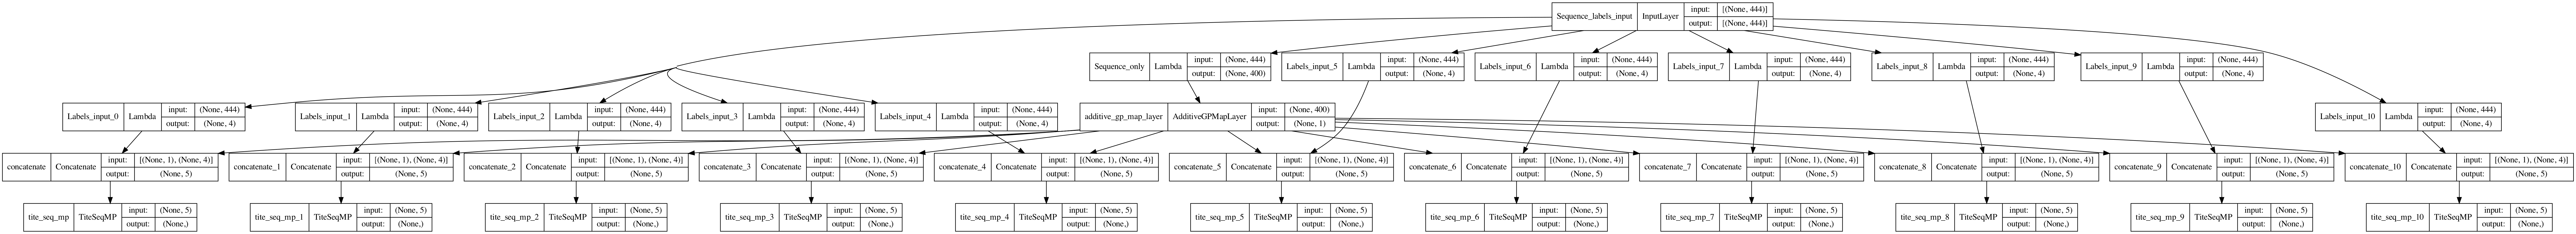

In [30]:
from tensorflow.keras.utils import plot_model
plot_model(model.model,show_shapes=True,show_dtype=False,dpi=200,to_file='pngs/Titeseq_MP/titeseq16_TSMP.png')


In [ ]:

# Fit model to data
model.fit(learning_rate=.001,
          epochs=1000,
          batch_size=200,
          try_tqdm = False,
          early_stopping=True,
          early_stopping_patience=100,
          linear_initialization=False)

Epoch 1/1000
42/42 [==============================] - 10s 44ms/step - loss: 8022914.0000 - tite_seq_mp_loss: 584790.6250 - tite_seq_mp_1_loss: 683281.4375 - tite_seq_mp_2_loss: 1138167.1250 - tite_seq_mp_3_loss: 786841.9375 - tite_seq_mp_4_loss: 552571.8750 - tite_seq_mp_5_loss: 300963.3750 - tite_seq_mp_6_loss: 379240.6875 - tite_seq_mp_7_loss: 1060501.2500 - tite_seq_mp_8_loss: 668146.9375 - tite_seq_mp_9_loss: 987396.2500 - tite_seq_mp_10_loss: 881012.7500 - I_var: -0.1302 - val_loss: 4023263.2500 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 370821.4375 - val_tite_seq_mp_2_loss: 600306.6875 - val_tite_seq_mp_3_loss: 397457.4062 - val_tite_seq_mp_4_loss: 288503.5312 - val_tite_seq_mp_5_loss: 177293.2031 - val_tite_seq_mp_6_loss: 186935.5469 - val_tite_seq_mp_7_loss: 442123.2500 - val_tite_seq_mp_8_loss: 303401.0938 - val_tite_seq_mp_9_loss: 480367.3750 - val_tite_seq_mp_10_loss: 429824.4688 - val_I_var: -0.1210
Epoch 2/1000
42/42 [==============================] - 0s

Epoch 10/1000
42/42 [==============================] - 0s 6ms/step - loss: 7554143.5000 - tite_seq_mp_loss: 584883.4375 - tite_seq_mp_1_loss: 586915.6250 - tite_seq_mp_2_loss: 1000381.3750 - tite_seq_mp_3_loss: 678388.4375 - tite_seq_mp_4_loss: 460377.0625 - tite_seq_mp_5_loss: 295465.5000 - tite_seq_mp_6_loss: 360498.1875 - tite_seq_mp_7_loss: 1057329.1250 - tite_seq_mp_8_loss: 662579.0000 - tite_seq_mp_9_loss: 986999.6250 - tite_seq_mp_10_loss: 880325.5625 - I_var: -0.1338 - val_loss: 3939652.0000 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 347308.7188 - val_tite_seq_mp_2_loss: 606552.1250 - val_tite_seq_mp_3_loss: 364715.5000 - val_tite_seq_mp_4_loss: 269343.7812 - val_tite_seq_mp_5_loss: 174797.6562 - val_tite_seq_mp_6_loss: 178212.0156 - val_tite_seq_mp_7_loss: 441122.9688 - val_tite_seq_mp_8_loss: 301517.4375 - val_tite_seq_mp_9_loss: 480218.9375 - val_tite_seq_mp_10_loss: 429633.5938 - val_I_var: -0.1201
Epoch 11/1000
42/42 [==============================] - 0s

Epoch 19/1000
42/42 [==============================] - 1s 18ms/step - loss: 7377306.5000 - tite_seq_mp_loss: 584503.8750 - tite_seq_mp_1_loss: 598660.8750 - tite_seq_mp_2_loss: 1054643.0000 - tite_seq_mp_3_loss: 590181.5000 - tite_seq_mp_4_loss: 426831.4062 - tite_seq_mp_5_loss: 275782.4062 - tite_seq_mp_6_loss: 329217.0938 - tite_seq_mp_7_loss: 1032287.0000 - tite_seq_mp_8_loss: 631000.3125 - tite_seq_mp_9_loss: 980515.8750 - tite_seq_mp_10_loss: 873682.5000 - I_var: -0.1227 - val_loss: 3945178.0000 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 361476.6250 - val_tite_seq_mp_2_loss: 644635.9375 - val_tite_seq_mp_3_loss: 349789.4375 - val_tite_seq_mp_4_loss: 271312.6562 - val_tite_seq_mp_5_loss: 168686.3281 - val_tite_seq_mp_6_loss: 167887.7188 - val_tite_seq_mp_7_loss: 434851.9375 - val_tite_seq_mp_8_loss: 293011.5938 - val_tite_seq_mp_9_loss: 479195.8125 - val_tite_seq_mp_10_loss: 428100.0938 - val_I_var: -0.1132
Epoch 20/1000
42/42 [==============================] - 1

Epoch 28/1000
42/42 [==============================] - 1s 18ms/step - loss: 7083093.0000 - tite_seq_mp_loss: 584536.8125 - tite_seq_mp_1_loss: 632040.5000 - tite_seq_mp_2_loss: 1117810.8750 - tite_seq_mp_3_loss: 619765.0625 - tite_seq_mp_4_loss: 453426.2500 - tite_seq_mp_5_loss: 249037.0156 - tite_seq_mp_6_loss: 321456.8750 - tite_seq_mp_7_loss: 867894.1250 - tite_seq_mp_8_loss: 530238.5000 - tite_seq_mp_9_loss: 900904.8750 - tite_seq_mp_10_loss: 805981.1875 - I_var: -0.0194 - val_loss: 4023399.7500 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 396128.0938 - val_tite_seq_mp_2_loss: 707262.0000 - val_tite_seq_mp_3_loss: 400858.1562 - val_tite_seq_mp_4_loss: 307917.8438 - val_tite_seq_mp_5_loss: 163892.3438 - val_tite_seq_mp_6_loss: 169896.0000 - val_tite_seq_mp_7_loss: 394590.0000 - val_tite_seq_mp_8_loss: 268552.6562 - val_tite_seq_mp_9_loss: 459058.2188 - val_tite_seq_mp_10_loss: 409014.9375 - val_I_var: -0.0272
Epoch 29/1000
42/42 [==============================] - 0s

Epoch 37/1000
42/42 [==============================] - 0s 8ms/step - loss: 6878864.0000 - tite_seq_mp_loss: 584503.6875 - tite_seq_mp_1_loss: 638506.6250 - tite_seq_mp_2_loss: 1126471.0000 - tite_seq_mp_3_loss: 642113.4375 - tite_seq_mp_4_loss: 463801.1875 - tite_seq_mp_5_loss: 251510.0156 - tite_seq_mp_6_loss: 328198.5312 - tite_seq_mp_7_loss: 791392.6250 - tite_seq_mp_8_loss: 505739.8125 - tite_seq_mp_9_loss: 818441.7500 - tite_seq_mp_10_loss: 728185.6875 - I_var: 0.0730 - val_loss: 3995685.0000 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 398669.2188 - val_tite_seq_mp_2_loss: 708416.4375 - val_tite_seq_mp_3_loss: 414203.7812 - val_tite_seq_mp_4_loss: 312852.5000 - val_tite_seq_mp_5_loss: 166591.8594 - val_tite_seq_mp_6_loss: 174174.9062 - val_tite_seq_mp_7_loss: 382397.8125 - val_tite_seq_mp_8_loss: 266685.0625 - val_tite_seq_mp_9_loss: 431542.4062 - val_tite_seq_mp_10_loss: 393921.4375 - val_I_var: 0.0408
Epoch 38/1000
42/42 [==============================] - 0s 8m

Epoch 46/1000
42/42 [==============================] - 1s 18ms/step - loss: 6776653.0000 - tite_seq_mp_loss: 584449.4375 - tite_seq_mp_1_loss: 627444.9375 - tite_seq_mp_2_loss: 1100804.3750 - tite_seq_mp_3_loss: 619514.9375 - tite_seq_mp_4_loss: 449400.8750 - tite_seq_mp_5_loss: 248177.4375 - tite_seq_mp_6_loss: 323531.3438 - tite_seq_mp_7_loss: 785535.1250 - tite_seq_mp_8_loss: 500951.7812 - tite_seq_mp_9_loss: 811807.9375 - tite_seq_mp_10_loss: 725034.7500 - I_var: 0.0717 - val_loss: 3910215.0000 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 388654.6562 - val_tite_seq_mp_2_loss: 686733.0000 - val_tite_seq_mp_3_loss: 393815.2500 - val_tite_seq_mp_4_loss: 300741.0000 - val_tite_seq_mp_5_loss: 163788.2344 - val_tite_seq_mp_6_loss: 170486.8750 - val_tite_seq_mp_7_loss: 378721.3125 - val_tite_seq_mp_8_loss: 263472.8438 - val_tite_seq_mp_9_loss: 426276.6562 - val_tite_seq_mp_10_loss: 391295.0938 - val_I_var: 0.0530
Epoch 47/1000
42/42 [==============================] - 1s 1

Epoch 55/1000
42/42 [==============================] - 1s 16ms/step - loss: 6704001.5000 - tite_seq_mp_loss: 584822.1250 - tite_seq_mp_1_loss: 618799.1875 - tite_seq_mp_2_loss: 1079244.6250 - tite_seq_mp_3_loss: 605453.7500 - tite_seq_mp_4_loss: 439307.1250 - tite_seq_mp_5_loss: 246674.5938 - tite_seq_mp_6_loss: 321149.4375 - tite_seq_mp_7_loss: 783602.4375 - tite_seq_mp_8_loss: 500128.1562 - tite_seq_mp_9_loss: 804813.0625 - tite_seq_mp_10_loss: 720005.6875 - I_var: 0.0931 - val_loss: 3835523.5000 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 378604.2188 - val_tite_seq_mp_2_loss: 663361.9375 - val_tite_seq_mp_3_loss: 376388.2188 - val_tite_seq_mp_4_loss: 289574.3438 - val_tite_seq_mp_5_loss: 161895.1875 - val_tite_seq_mp_6_loss: 167505.1406 - val_tite_seq_mp_7_loss: 376636.3438 - val_tite_seq_mp_8_loss: 261599.1875 - val_tite_seq_mp_9_loss: 423529.5938 - val_tite_seq_mp_10_loss: 390199.3750 - val_I_var: 0.0583
Epoch 56/1000
42/42 [==============================] - 1s 1

Epoch 64/1000
42/42 [==============================] - 0s 5ms/step - loss: 6635598.0000 - tite_seq_mp_loss: 584592.6875 - tite_seq_mp_1_loss: 611926.1875 - tite_seq_mp_2_loss: 1062437.7500 - tite_seq_mp_3_loss: 597148.8125 - tite_seq_mp_4_loss: 432425.1562 - tite_seq_mp_5_loss: 245931.4375 - tite_seq_mp_6_loss: 319746.8438 - tite_seq_mp_7_loss: 780627.3750 - tite_seq_mp_8_loss: 498305.5625 - tite_seq_mp_9_loss: 792650.0625 - tite_seq_mp_10_loss: 709806.6875 - I_var: 0.1007 - val_loss: 3787202.7500 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 372672.0938 - val_tite_seq_mp_2_loss: 647867.1875 - val_tite_seq_mp_3_loss: 368427.0938 - val_tite_seq_mp_4_loss: 283716.1875 - val_tite_seq_mp_5_loss: 161295.2344 - val_tite_seq_mp_6_loss: 166452.5156 - val_tite_seq_mp_7_loss: 374793.5000 - val_tite_seq_mp_8_loss: 260723.0312 - val_tite_seq_mp_9_loss: 417451.5000 - val_tite_seq_mp_10_loss: 387574.1875 - val_I_var: 0.0705
Epoch 65/1000
42/42 [==============================] - 0s 5m

Epoch 73/1000
42/42 [==============================] - 1s 13ms/step - loss: 6586948.0000 - tite_seq_mp_loss: 584735.6875 - tite_seq_mp_1_loss: 606535.0000 - tite_seq_mp_2_loss: 1046866.7500 - tite_seq_mp_3_loss: 590650.0625 - tite_seq_mp_4_loss: 426752.7500 - tite_seq_mp_5_loss: 245614.7031 - tite_seq_mp_6_loss: 318897.7812 - tite_seq_mp_7_loss: 780291.9375 - tite_seq_mp_8_loss: 497669.0312 - tite_seq_mp_9_loss: 784823.2500 - tite_seq_mp_10_loss: 704109.7500 - I_var: 0.1124 - val_loss: 3739663.5000 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 365886.5938 - val_tite_seq_mp_2_loss: 630010.7500 - val_tite_seq_mp_3_loss: 358982.4688 - val_tite_seq_mp_4_loss: 276988.0938 - val_tite_seq_mp_5_loss: 160631.7031 - val_tite_seq_mp_6_loss: 165067.7188 - val_tite_seq_mp_7_loss: 373839.8125 - val_tite_seq_mp_8_loss: 260163.3125 - val_tite_seq_mp_9_loss: 415089.1562 - val_tite_seq_mp_10_loss: 386773.6875 - val_I_var: 0.0743
Epoch 74/1000
42/42 [==============================] - 0s 1

Epoch 82/1000
42/42 [==============================] - 0s 11ms/step - loss: 6544207.5000 - tite_seq_mp_loss: 584676.1875 - tite_seq_mp_1_loss: 600886.3750 - tite_seq_mp_2_loss: 1031956.1250 - tite_seq_mp_3_loss: 583927.6250 - tite_seq_mp_4_loss: 421134.9688 - tite_seq_mp_5_loss: 245087.7344 - tite_seq_mp_6_loss: 317796.1562 - tite_seq_mp_7_loss: 779735.5625 - tite_seq_mp_8_loss: 497253.5625 - tite_seq_mp_9_loss: 780397.4375 - tite_seq_mp_10_loss: 701355.0000 - I_var: 0.1142 - val_loss: 3705012.5000 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 361173.3438 - val_tite_seq_mp_2_loss: 617009.1875 - val_tite_seq_mp_3_loss: 353017.7188 - val_tite_seq_mp_4_loss: 272496.8438 - val_tite_seq_mp_5_loss: 160318.0625 - val_tite_seq_mp_6_loss: 164309.6406 - val_tite_seq_mp_7_loss: 373015.5625 - val_tite_seq_mp_8_loss: 259830.4062 - val_tite_seq_mp_9_loss: 412025.5938 - val_tite_seq_mp_10_loss: 385585.4688 - val_I_var: 0.0799
Epoch 83/1000
42/42 [==============================] - 1s 1

Epoch 91/1000
42/42 [==============================] - 0s 11ms/step - loss: 6511934.5000 - tite_seq_mp_loss: 584731.5625 - tite_seq_mp_1_loss: 596717.1875 - tite_seq_mp_2_loss: 1020567.6250 - tite_seq_mp_3_loss: 579503.4375 - tite_seq_mp_4_loss: 416946.3125 - tite_seq_mp_5_loss: 245031.2031 - tite_seq_mp_6_loss: 317295.1875 - tite_seq_mp_7_loss: 780270.2500 - tite_seq_mp_8_loss: 496941.2188 - tite_seq_mp_9_loss: 776374.8125 - tite_seq_mp_10_loss: 697555.0000 - I_var: 0.1244 - val_loss: 3676462.5000 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 357193.0312 - val_tite_seq_mp_2_loss: 606130.3125 - val_tite_seq_mp_3_loss: 348008.5938 - val_tite_seq_mp_4_loss: 268679.5625 - val_tite_seq_mp_5_loss: 160110.0938 - val_tite_seq_mp_6_loss: 163710.9844 - val_tite_seq_mp_7_loss: 372408.6250 - val_tite_seq_mp_8_loss: 259620.8906 - val_tite_seq_mp_9_loss: 409679.9375 - val_tite_seq_mp_10_loss: 384690.1562 - val_I_var: 0.0842
Epoch 92/1000
42/42 [==============================] - 0s 1

Epoch 100/1000
42/42 [==============================] - 1s 13ms/step - loss: 6359093.5000 - tite_seq_mp_loss: 570862.3125 - tite_seq_mp_1_loss: 581376.8125 - tite_seq_mp_2_loss: 977344.1875 - tite_seq_mp_3_loss: 563282.1250 - tite_seq_mp_4_loss: 402991.7500 - tite_seq_mp_5_loss: 243912.8750 - tite_seq_mp_6_loss: 314513.2812 - tite_seq_mp_7_loss: 768183.8750 - tite_seq_mp_8_loss: 483759.4688 - tite_seq_mp_9_loss: 764492.1250 - tite_seq_mp_10_loss: 688372.8125 - I_var: 0.1247 - val_loss: 3648817.2500 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 352575.4375 - val_tite_seq_mp_2_loss: 594522.7500 - val_tite_seq_mp_3_loss: 341959.0312 - val_tite_seq_mp_4_loss: 264061.0938 - val_tite_seq_mp_5_loss: 159996.9062 - val_tite_seq_mp_6_loss: 163032.8906 - val_tite_seq_mp_7_loss: 372324.1875 - val_tite_seq_mp_8_loss: 259707.5312 - val_tite_seq_mp_9_loss: 409469.3438 - val_tite_seq_mp_10_loss: 384937.5000 - val_I_var: 0.0832
Epoch 101/1000
42/42 [==============================] - 1s 

Epoch 109/1000
42/42 [==============================] - 1s 12ms/step - loss: 6456144.0000 - tite_seq_mp_loss: 584469.9375 - tite_seq_mp_1_loss: 589785.8750 - tite_seq_mp_2_loss: 1002571.5000 - tite_seq_mp_3_loss: 572220.1875 - tite_seq_mp_4_loss: 410150.5625 - tite_seq_mp_5_loss: 244853.3750 - tite_seq_mp_6_loss: 316343.1250 - tite_seq_mp_7_loss: 779913.3125 - tite_seq_mp_8_loss: 496023.9688 - tite_seq_mp_9_loss: 767417.1875 - tite_seq_mp_10_loss: 692393.4375 - I_var: 0.1285 - val_loss: 3632702.0000 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 350779.4062 - val_tite_seq_mp_2_loss: 589590.5625 - val_tite_seq_mp_3_loss: 340016.7500 - val_tite_seq_mp_4_loss: 262405.2188 - val_tite_seq_mp_5_loss: 159904.9531 - val_tite_seq_mp_6_loss: 162873.4375 - val_tite_seq_mp_7_loss: 371603.4688 - val_tite_seq_mp_8_loss: 259401.7656 - val_tite_seq_mp_9_loss: 406419.0312 - val_tite_seq_mp_10_loss: 383476.5312 - val_I_var: 0.0900
Epoch 110/1000
42/42 [==============================] - 0s

Epoch 118/1000
42/42 [==============================] - 1s 15ms/step - loss: 6441352.0000 - tite_seq_mp_loss: 584699.0625 - tite_seq_mp_1_loss: 587193.6875 - tite_seq_mp_2_loss: 995782.5625 - tite_seq_mp_3_loss: 569544.7500 - tite_seq_mp_4_loss: 407598.2500 - tite_seq_mp_5_loss: 244737.8906 - tite_seq_mp_6_loss: 316201.4375 - tite_seq_mp_7_loss: 780822.1875 - tite_seq_mp_8_loss: 496284.1562 - tite_seq_mp_9_loss: 767516.6250 - tite_seq_mp_10_loss: 690969.5625 - I_var: 0.1323 - val_loss: 3614005.2500 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 347548.9062 - val_tite_seq_mp_2_loss: 582189.2500 - val_tite_seq_mp_3_loss: 336186.9375 - val_tite_seq_mp_4_loss: 259227.5312 - val_tite_seq_mp_5_loss: 159892.6875 - val_tite_seq_mp_6_loss: 162542.0000 - val_tite_seq_mp_7_loss: 371449.5938 - val_tite_seq_mp_8_loss: 259434.5625 - val_tite_seq_mp_9_loss: 405872.9688 - val_tite_seq_mp_10_loss: 383429.9375 - val_I_var: 0.0903
Epoch 119/1000
42/42 [==============================] - 1s 

Epoch 127/1000
42/42 [==============================] - 1s 13ms/step - loss: 6424006.5000 - tite_seq_mp_loss: 584793.2500 - tite_seq_mp_1_loss: 584555.1250 - tite_seq_mp_2_loss: 989670.6875 - tite_seq_mp_3_loss: 566974.5000 - tite_seq_mp_4_loss: 405056.8125 - tite_seq_mp_5_loss: 244779.2656 - tite_seq_mp_6_loss: 315966.9688 - tite_seq_mp_7_loss: 780523.3750 - tite_seq_mp_8_loss: 496262.2188 - tite_seq_mp_9_loss: 765186.6250 - tite_seq_mp_10_loss: 690235.3125 - I_var: 0.1221 - val_loss: 3600573.5000 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 345679.9375 - val_tite_seq_mp_2_loss: 577915.4375 - val_tite_seq_mp_3_loss: 334197.5625 - val_tite_seq_mp_4_loss: 257472.8750 - val_tite_seq_mp_5_loss: 159833.9062 - val_tite_seq_mp_6_loss: 162387.6562 - val_tite_seq_mp_7_loss: 370983.2500 - val_tite_seq_mp_8_loss: 259221.5938 - val_tite_seq_mp_9_loss: 404075.7500 - val_tite_seq_mp_10_loss: 382574.4688 - val_I_var: 0.0943
Epoch 128/1000
42/42 [==============================] - 1s 

Epoch 136/1000
42/42 [==============================] - 0s 11ms/step - loss: 6227999.5000 - tite_seq_mp_loss: 573301.6875 - tite_seq_mp_1_loss: 565876.8750 - tite_seq_mp_2_loss: 969423.8125 - tite_seq_mp_3_loss: 546933.7500 - tite_seq_mp_4_loss: 397720.2812 - tite_seq_mp_5_loss: 238197.5156 - tite_seq_mp_6_loss: 303705.1875 - tite_seq_mp_7_loss: 736021.3125 - tite_seq_mp_8_loss: 486481.5938 - tite_seq_mp_9_loss: 740404.8125 - tite_seq_mp_10_loss: 669931.7500 - I_var: 0.1311 - val_loss: 3587892.0000 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 343711.1562 - val_tite_seq_mp_2_loss: 573637.0000 - val_tite_seq_mp_3_loss: 332220.3125 - val_tite_seq_mp_4_loss: 255652.3750 - val_tite_seq_mp_5_loss: 159798.5000 - val_tite_seq_mp_6_loss: 162250.8125 - val_tite_seq_mp_7_loss: 370609.2500 - val_tite_seq_mp_8_loss: 259058.6406 - val_tite_seq_mp_9_loss: 402770.5000 - val_tite_seq_mp_10_loss: 381951.7188 - val_I_var: 0.0972
Epoch 137/1000
42/42 [==============================] - 1s 

Epoch 145/1000
42/42 [==============================] - 0s 12ms/step - loss: 6393277.0000 - tite_seq_mp_loss: 584701.5000 - tite_seq_mp_1_loss: 580962.8750 - tite_seq_mp_2_loss: 980959.3125 - tite_seq_mp_3_loss: 564020.5000 - tite_seq_mp_4_loss: 401803.0938 - tite_seq_mp_5_loss: 244616.6719 - tite_seq_mp_6_loss: 315758.9062 - tite_seq_mp_7_loss: 781686.8125 - tite_seq_mp_8_loss: 495546.3438 - tite_seq_mp_9_loss: 758552.1250 - tite_seq_mp_10_loss: 684666.8750 - I_var: 0.1392 - val_loss: 3577265.2500 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 342249.7812 - val_tite_seq_mp_2_loss: 570485.4375 - val_tite_seq_mp_3_loss: 330850.0000 - val_tite_seq_mp_4_loss: 254349.0312 - val_tite_seq_mp_5_loss: 159730.2031 - val_tite_seq_mp_6_loss: 162154.0312 - val_tite_seq_mp_7_loss: 370169.8125 - val_tite_seq_mp_8_loss: 258800.4688 - val_tite_seq_mp_9_loss: 401151.3438 - val_tite_seq_mp_10_loss: 381093.7188 - val_I_var: 0.1012
Epoch 146/1000
42/42 [==============================] - 1s 

Epoch 154/1000
42/42 [==============================] - 0s 11ms/step - loss: 6381787.0000 - tite_seq_mp_loss: 584784.3750 - tite_seq_mp_1_loss: 579100.1875 - tite_seq_mp_2_loss: 976083.3125 - tite_seq_mp_3_loss: 562554.0000 - tite_seq_mp_4_loss: 400126.8750 - tite_seq_mp_5_loss: 244657.0938 - tite_seq_mp_6_loss: 315706.2188 - tite_seq_mp_7_loss: 783393.6875 - tite_seq_mp_8_loss: 495889.1250 - tite_seq_mp_9_loss: 756583.5625 - tite_seq_mp_10_loss: 682906.3750 - I_var: 0.1422 - val_loss: 3565480.0000 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 340025.8750 - val_tite_seq_mp_2_loss: 565833.9375 - val_tite_seq_mp_3_loss: 328942.5938 - val_tite_seq_mp_4_loss: 252404.6094 - val_tite_seq_mp_5_loss: 159748.3438 - val_tite_seq_mp_6_loss: 162065.1406 - val_tite_seq_mp_7_loss: 369938.4688 - val_tite_seq_mp_8_loss: 258740.1406 - val_tite_seq_mp_9_loss: 400643.0938 - val_tite_seq_mp_10_loss: 380906.0625 - val_I_var: 0.1022
Epoch 155/1000
42/42 [==============================] - 0s 

Epoch 163/1000
42/42 [==============================] - 0s 11ms/step - loss: 6368072.5000 - tite_seq_mp_loss: 584654.5000 - tite_seq_mp_1_loss: 576696.0625 - tite_seq_mp_2_loss: 970549.1250 - tite_seq_mp_3_loss: 560607.5000 - tite_seq_mp_4_loss: 398136.1562 - tite_seq_mp_5_loss: 244595.3125 - tite_seq_mp_6_loss: 315638.6250 - tite_seq_mp_7_loss: 782460.4375 - tite_seq_mp_8_loss: 495479.0312 - tite_seq_mp_9_loss: 756202.3750 - tite_seq_mp_10_loss: 683052.3125 - I_var: 0.1423 - val_loss: 3555883.5000 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 338500.0938 - val_tite_seq_mp_2_loss: 562488.8750 - val_tite_seq_mp_3_loss: 327743.7500 - val_tite_seq_mp_4_loss: 251129.0156 - val_tite_seq_mp_5_loss: 159715.7969 - val_tite_seq_mp_6_loss: 162006.4375 - val_tite_seq_mp_7_loss: 369593.3125 - val_tite_seq_mp_8_loss: 258547.6875 - val_tite_seq_mp_9_loss: 399602.3125 - val_tite_seq_mp_10_loss: 380324.4375 - val_I_var: 0.1049
Epoch 164/1000
42/42 [==============================] - 0s 

Epoch 172/1000
42/42 [==============================] - 0s 11ms/step - loss: 6358137.0000 - tite_seq_mp_loss: 584563.5000 - tite_seq_mp_1_loss: 574797.6875 - tite_seq_mp_2_loss: 965457.8125 - tite_seq_mp_3_loss: 559501.2500 - tite_seq_mp_4_loss: 396616.6875 - tite_seq_mp_5_loss: 244648.3906 - tite_seq_mp_6_loss: 315628.6562 - tite_seq_mp_7_loss: 782264.0625 - tite_seq_mp_8_loss: 495228.0000 - tite_seq_mp_9_loss: 756458.3125 - tite_seq_mp_10_loss: 682970.0000 - I_var: 0.1455 - val_loss: 3543987.5000 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 335597.5000 - val_tite_seq_mp_2_loss: 556010.9375 - val_tite_seq_mp_3_loss: 325810.6562 - val_tite_seq_mp_4_loss: 248787.5469 - val_tite_seq_mp_5_loss: 159868.6562 - val_tite_seq_mp_6_loss: 162027.1250 - val_tite_seq_mp_7_loss: 369601.8750 - val_tite_seq_mp_8_loss: 258744.0312 - val_tite_seq_mp_9_loss: 400351.9375 - val_tite_seq_mp_10_loss: 380954.9062 - val_I_var: 0.1021
Epoch 173/1000
42/42 [==============================] - 1s 

Epoch 181/1000
42/42 [==============================] - 0s 11ms/step - loss: 6346539.0000 - tite_seq_mp_loss: 584655.6250 - tite_seq_mp_1_loss: 574306.5625 - tite_seq_mp_2_loss: 964055.6875 - tite_seq_mp_3_loss: 559067.5000 - tite_seq_mp_4_loss: 396260.9375 - tite_seq_mp_5_loss: 244480.5156 - tite_seq_mp_6_loss: 315494.1875 - tite_seq_mp_7_loss: 784391.3750 - tite_seq_mp_8_loss: 494998.0625 - tite_seq_mp_9_loss: 750754.1875 - tite_seq_mp_10_loss: 678070.5625 - I_var: 0.1569 - val_loss: 3537238.2500 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 334981.9375 - val_tite_seq_mp_2_loss: 554409.3125 - val_tite_seq_mp_3_loss: 325434.3750 - val_tite_seq_mp_4_loss: 248342.0938 - val_tite_seq_mp_5_loss: 159770.0156 - val_tite_seq_mp_6_loss: 161979.3281 - val_tite_seq_mp_7_loss: 369141.0625 - val_tite_seq_mp_8_loss: 258402.1719 - val_tite_seq_mp_9_loss: 398663.1250 - val_tite_seq_mp_10_loss: 379882.6250 - val_I_var: 0.1071
Epoch 182/1000
42/42 [==============================] - 1s 

Epoch 190/1000
42/42 [==============================] - 1s 12ms/step - loss: 6340206.5000 - tite_seq_mp_loss: 584681.1250 - tite_seq_mp_1_loss: 572995.1250 - tite_seq_mp_2_loss: 960305.4375 - tite_seq_mp_3_loss: 558446.2500 - tite_seq_mp_4_loss: 395147.0938 - tite_seq_mp_5_loss: 244594.7188 - tite_seq_mp_6_loss: 315663.5312 - tite_seq_mp_7_loss: 785728.8125 - tite_seq_mp_8_loss: 494993.0000 - tite_seq_mp_9_loss: 750502.2500 - tite_seq_mp_10_loss: 677146.0625 - I_var: 0.1532 - val_loss: 3530342.5000 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 334048.9062 - val_tite_seq_mp_2_loss: 551999.9375 - val_tite_seq_mp_3_loss: 324910.5312 - val_tite_seq_mp_4_loss: 247660.2812 - val_tite_seq_mp_5_loss: 159732.2188 - val_tite_seq_mp_6_loss: 161965.4688 - val_tite_seq_mp_7_loss: 368846.3750 - val_tite_seq_mp_8_loss: 258193.4375 - val_tite_seq_mp_9_loss: 397557.4062 - val_tite_seq_mp_10_loss: 379196.0938 - val_I_var: 0.1103
Epoch 191/1000
42/42 [==============================] - 0s 

Epoch 199/1000
42/42 [==============================] - 0s 11ms/step - loss: 6328599.5000 - tite_seq_mp_loss: 584388.8750 - tite_seq_mp_1_loss: 571050.1875 - tite_seq_mp_2_loss: 955125.8125 - tite_seq_mp_3_loss: 557295.7500 - tite_seq_mp_4_loss: 393623.0312 - tite_seq_mp_5_loss: 244512.7344 - tite_seq_mp_6_loss: 315389.5625 - tite_seq_mp_7_loss: 784428.8125 - tite_seq_mp_8_loss: 494756.1875 - tite_seq_mp_9_loss: 750556.6875 - tite_seq_mp_10_loss: 677469.3125 - I_var: 0.1483 - val_loss: 3523376.7500 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 332878.1875 - val_tite_seq_mp_2_loss: 548880.2500 - val_tite_seq_mp_3_loss: 324318.8750 - val_tite_seq_mp_4_loss: 246809.2188 - val_tite_seq_mp_5_loss: 159745.8125 - val_tite_seq_mp_6_loss: 161981.5625 - val_tite_seq_mp_7_loss: 368647.9062 - val_tite_seq_mp_8_loss: 258093.1875 - val_tite_seq_mp_9_loss: 396955.2500 - val_tite_seq_mp_10_loss: 378834.0938 - val_I_var: 0.1120
Epoch 200/1000
42/42 [==============================] - 0s 

Epoch 208/1000
42/42 [==============================] - 0s 5ms/step - loss: 6325886.0000 - tite_seq_mp_loss: 584785.3125 - tite_seq_mp_1_loss: 570585.8125 - tite_seq_mp_2_loss: 953439.8750 - tite_seq_mp_3_loss: 557131.0000 - tite_seq_mp_4_loss: 393353.2500 - tite_seq_mp_5_loss: 244525.2188 - tite_seq_mp_6_loss: 315602.0625 - tite_seq_mp_7_loss: 785049.7500 - tite_seq_mp_8_loss: 494842.5938 - tite_seq_mp_9_loss: 749745.6875 - tite_seq_mp_10_loss: 676822.6250 - I_var: 0.1549 - val_loss: 3517321.2500 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 331942.7500 - val_tite_seq_mp_2_loss: 546235.6250 - val_tite_seq_mp_3_loss: 323882.5625 - val_tite_seq_mp_4_loss: 246150.9062 - val_tite_seq_mp_5_loss: 159749.8438 - val_tite_seq_mp_6_loss: 161999.7344 - val_tite_seq_mp_7_loss: 368473.5000 - val_tite_seq_mp_8_loss: 257979.9531 - val_tite_seq_mp_9_loss: 396271.1250 - val_tite_seq_mp_10_loss: 378402.7812 - val_I_var: 0.1140
Epoch 209/1000
42/42 [==============================] - 0s 1

Epoch 217/1000
42/42 [==============================] - 0s 11ms/step - loss: 6313498.5000 - tite_seq_mp_loss: 580923.7500 - tite_seq_mp_1_loss: 569330.1250 - tite_seq_mp_2_loss: 949437.8750 - tite_seq_mp_3_loss: 556518.0625 - tite_seq_mp_4_loss: 392318.9688 - tite_seq_mp_5_loss: 244500.0000 - tite_seq_mp_6_loss: 315580.9375 - tite_seq_mp_7_loss: 784377.6875 - tite_seq_mp_8_loss: 494710.8438 - tite_seq_mp_9_loss: 748924.4375 - tite_seq_mp_10_loss: 676873.3750 - I_var: 0.1456 - val_loss: 3510669.2500 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 330535.7812 - val_tite_seq_mp_2_loss: 542170.7500 - val_tite_seq_mp_3_loss: 323300.0625 - val_tite_seq_mp_4_loss: 245155.7969 - val_tite_seq_mp_5_loss: 159848.8438 - val_tite_seq_mp_6_loss: 162081.3438 - val_tite_seq_mp_7_loss: 368355.0312 - val_tite_seq_mp_8_loss: 258037.3906 - val_tite_seq_mp_9_loss: 396392.0938 - val_tite_seq_mp_10_loss: 378559.4688 - val_I_var: 0.1134
Epoch 218/1000
42/42 [==============================] - 0s 

Epoch 226/1000
42/42 [==============================] - 0s 11ms/step - loss: 6311341.0000 - tite_seq_mp_loss: 584637.4375 - tite_seq_mp_1_loss: 568923.0625 - tite_seq_mp_2_loss: 948322.4375 - tite_seq_mp_3_loss: 556275.2500 - tite_seq_mp_4_loss: 392249.7188 - tite_seq_mp_5_loss: 244386.6250 - tite_seq_mp_6_loss: 315577.4375 - tite_seq_mp_7_loss: 785907.2500 - tite_seq_mp_8_loss: 494649.9062 - tite_seq_mp_9_loss: 746058.8125 - tite_seq_mp_10_loss: 674349.0000 - I_var: 0.1563 - val_loss: 3506775.2500 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 330296.7500 - val_tite_seq_mp_2_loss: 541189.2500 - val_tite_seq_mp_3_loss: 323194.8750 - val_tite_seq_mp_4_loss: 245023.0469 - val_tite_seq_mp_5_loss: 159789.1875 - val_tite_seq_mp_6_loss: 162060.1719 - val_tite_seq_mp_7_loss: 368235.1875 - val_tite_seq_mp_8_loss: 257834.8906 - val_tite_seq_mp_9_loss: 395200.5312 - val_tite_seq_mp_10_loss: 377718.7812 - val_I_var: 0.1173
Epoch 227/1000
42/42 [==============================] - 0s 

Epoch 235/1000
42/42 [==============================] - 0s 10ms/step - loss: 6308075.5000 - tite_seq_mp_loss: 584715.3125 - tite_seq_mp_1_loss: 568549.0625 - tite_seq_mp_2_loss: 946456.6250 - tite_seq_mp_3_loss: 556161.0625 - tite_seq_mp_4_loss: 391855.8438 - tite_seq_mp_5_loss: 244500.7188 - tite_seq_mp_6_loss: 315690.3438 - tite_seq_mp_7_loss: 787377.5000 - tite_seq_mp_8_loss: 494674.1875 - tite_seq_mp_9_loss: 745173.7500 - tite_seq_mp_10_loss: 672917.5625 - I_var: 0.1588 - val_loss: 3502777.2500 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 329818.9688 - val_tite_seq_mp_2_loss: 539517.5625 - val_tite_seq_mp_3_loss: 323008.1875 - val_tite_seq_mp_4_loss: 244715.4375 - val_tite_seq_mp_5_loss: 159784.5312 - val_tite_seq_mp_6_loss: 162074.1562 - val_tite_seq_mp_7_loss: 368191.0000 - val_tite_seq_mp_8_loss: 257733.7969 - val_tite_seq_mp_9_loss: 394484.6875 - val_tite_seq_mp_10_loss: 377216.0625 - val_I_var: 0.1196
Epoch 236/1000
42/42 [==============================] - 1s 

Epoch 244/1000
42/42 [==============================] - 0s 11ms/step - loss: 6304388.0000 - tite_seq_mp_loss: 584603.2500 - tite_seq_mp_1_loss: 567287.6875 - tite_seq_mp_2_loss: 942818.3125 - tite_seq_mp_3_loss: 555762.5000 - tite_seq_mp_4_loss: 390957.8125 - tite_seq_mp_5_loss: 244662.3594 - tite_seq_mp_6_loss: 315842.3438 - tite_seq_mp_7_loss: 786523.1250 - tite_seq_mp_8_loss: 494760.8750 - tite_seq_mp_9_loss: 746711.3125 - tite_seq_mp_10_loss: 674455.8125 - I_var: 0.1586 - val_loss: 3498135.5000 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 328914.5000 - val_tite_seq_mp_2_loss: 536553.0000 - val_tite_seq_mp_3_loss: 322692.3750 - val_tite_seq_mp_4_loss: 244093.2812 - val_tite_seq_mp_5_loss: 159863.0312 - val_tite_seq_mp_6_loss: 162152.2812 - val_tite_seq_mp_7_loss: 368094.4062 - val_tite_seq_mp_8_loss: 257773.0625 - val_tite_seq_mp_9_loss: 394495.4688 - val_tite_seq_mp_10_loss: 377271.1875 - val_I_var: 0.1194
Epoch 245/1000
42/42 [==============================] - 0s 

Epoch 253/1000
42/42 [==============================] - 0s 12ms/step - loss: 6299890.5000 - tite_seq_mp_loss: 584794.4375 - tite_seq_mp_1_loss: 566953.1250 - tite_seq_mp_2_loss: 941081.2500 - tite_seq_mp_3_loss: 555487.4375 - tite_seq_mp_4_loss: 390716.9375 - tite_seq_mp_5_loss: 244618.6562 - tite_seq_mp_6_loss: 315810.5625 - tite_seq_mp_7_loss: 786239.4375 - tite_seq_mp_8_loss: 494439.2188 - tite_seq_mp_9_loss: 745901.8125 - tite_seq_mp_10_loss: 673843.5000 - I_var: 0.1580 - val_loss: 3494476.7500 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 328331.7500 - val_tite_seq_mp_2_loss: 534471.7500 - val_tite_seq_mp_3_loss: 322495.0000 - val_tite_seq_mp_4_loss: 243701.3125 - val_tite_seq_mp_5_loss: 159904.1094 - val_tite_seq_mp_6_loss: 162202.5938 - val_tite_seq_mp_7_loss: 368053.4688 - val_tite_seq_mp_8_loss: 257759.0625 - val_tite_seq_mp_9_loss: 394214.1875 - val_tite_seq_mp_10_loss: 377109.9375 - val_I_var: 0.1202
Epoch 254/1000
42/42 [==============================] - 0s 

Epoch 262/1000
42/42 [==============================] - 0s 11ms/step - loss: 6298737.0000 - tite_seq_mp_loss: 584659.5625 - tite_seq_mp_1_loss: 567167.1875 - tite_seq_mp_2_loss: 941672.6250 - tite_seq_mp_3_loss: 555576.1250 - tite_seq_mp_4_loss: 390927.2500 - tite_seq_mp_5_loss: 244511.4688 - tite_seq_mp_6_loss: 315766.5938 - tite_seq_mp_7_loss: 790205.3125 - tite_seq_mp_8_loss: 494455.8125 - tite_seq_mp_9_loss: 743479.5625 - tite_seq_mp_10_loss: 670313.0625 - I_var: 0.1632 - val_loss: 3492079.2500 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 328217.0312 - val_tite_seq_mp_2_loss: 533800.6250 - val_tite_seq_mp_3_loss: 322435.5000 - val_tite_seq_mp_4_loss: 243647.8750 - val_tite_seq_mp_5_loss: 159870.6875 - val_tite_seq_mp_6_loss: 162194.0156 - val_tite_seq_mp_7_loss: 368130.1562 - val_tite_seq_mp_8_loss: 257652.8750 - val_tite_seq_mp_9_loss: 393396.2188 - val_tite_seq_mp_10_loss: 376501.2500 - val_I_var: 0.1230
Epoch 263/1000
42/42 [==============================] - 0s 

Epoch 271/1000
42/42 [==============================] - 0s 10ms/step - loss: 6291246.0000 - tite_seq_mp_loss: 584651.8125 - tite_seq_mp_1_loss: 566650.8125 - tite_seq_mp_2_loss: 940297.6875 - tite_seq_mp_3_loss: 555289.2500 - tite_seq_mp_4_loss: 390720.3125 - tite_seq_mp_5_loss: 244378.3906 - tite_seq_mp_6_loss: 315708.4062 - tite_seq_mp_7_loss: 789458.0625 - tite_seq_mp_8_loss: 494349.3438 - tite_seq_mp_9_loss: 740183.0000 - tite_seq_mp_10_loss: 669555.7500 - I_var: 0.1622 - val_loss: 3489646.0000 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 327968.5312 - val_tite_seq_mp_2_loss: 532695.4375 - val_tite_seq_mp_3_loss: 322333.1875 - val_tite_seq_mp_4_loss: 243491.8594 - val_tite_seq_mp_5_loss: 159870.9531 - val_tite_seq_mp_6_loss: 162207.4375 - val_tite_seq_mp_7_loss: 368203.6562 - val_tite_seq_mp_8_loss: 257605.0000 - val_tite_seq_mp_9_loss: 392895.3125 - val_tite_seq_mp_10_loss: 376140.9375 - val_I_var: 0.1247
Epoch 272/1000
42/42 [==============================] - 0s 

Epoch 280/1000
42/42 [==============================] - 0s 12ms/step - loss: 6290727.0000 - tite_seq_mp_loss: 584633.6250 - tite_seq_mp_1_loss: 566235.3750 - tite_seq_mp_2_loss: 938497.8125 - tite_seq_mp_3_loss: 555285.9375 - tite_seq_mp_4_loss: 390258.5938 - tite_seq_mp_5_loss: 244529.5156 - tite_seq_mp_6_loss: 315841.1250 - tite_seq_mp_7_loss: 791251.3125 - tite_seq_mp_8_loss: 494474.8125 - tite_seq_mp_9_loss: 740776.3125 - tite_seq_mp_10_loss: 668938.4375 - I_var: 0.1679 - val_loss: 3486649.0000 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 327373.8125 - val_tite_seq_mp_2_loss: 530565.6875 - val_tite_seq_mp_3_loss: 322158.0938 - val_tite_seq_mp_4_loss: 243073.5938 - val_tite_seq_mp_5_loss: 159947.1406 - val_tite_seq_mp_6_loss: 162290.7656 - val_tite_seq_mp_7_loss: 368124.5938 - val_tite_seq_mp_8_loss: 257664.1250 - val_tite_seq_mp_9_loss: 392970.4688 - val_tite_seq_mp_10_loss: 376247.2500 - val_I_var: 0.1242
Epoch 281/1000
42/42 [==============================] - 1s 

Epoch 289/1000
42/42 [==============================] - 0s 11ms/step - loss: 6286841.5000 - tite_seq_mp_loss: 584650.6875 - tite_seq_mp_1_loss: 565704.3125 - tite_seq_mp_2_loss: 936740.0625 - tite_seq_mp_3_loss: 555047.0000 - tite_seq_mp_4_loss: 389994.2812 - tite_seq_mp_5_loss: 244539.5469 - tite_seq_mp_6_loss: 315838.5938 - tite_seq_mp_7_loss: 789273.2500 - tite_seq_mp_8_loss: 494323.5000 - tite_seq_mp_9_loss: 740907.8750 - tite_seq_mp_10_loss: 669818.8125 - I_var: 0.1664 - val_loss: 3484535.7500 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 327091.2812 - val_tite_seq_mp_2_loss: 529388.8750 - val_tite_seq_mp_3_loss: 322056.1875 - val_tite_seq_mp_4_loss: 242881.3438 - val_tite_seq_mp_5_loss: 159972.0000 - val_tite_seq_mp_6_loss: 162325.1406 - val_tite_seq_mp_7_loss: 368163.5938 - val_tite_seq_mp_8_loss: 257658.7812 - val_tite_seq_mp_9_loss: 392695.5938 - val_tite_seq_mp_10_loss: 376068.9688 - val_I_var: 0.1250
Epoch 290/1000
42/42 [==============================] - 0s 

Epoch 298/1000
42/42 [==============================] - 0s 11ms/step - loss: 6287553.0000 - tite_seq_mp_loss: 584828.6875 - tite_seq_mp_1_loss: 565685.6875 - tite_seq_mp_2_loss: 936091.3125 - tite_seq_mp_3_loss: 555094.5625 - tite_seq_mp_4_loss: 389826.4688 - tite_seq_mp_5_loss: 244627.4375 - tite_seq_mp_6_loss: 315961.7812 - tite_seq_mp_7_loss: 790110.2500 - tite_seq_mp_8_loss: 494551.1562 - tite_seq_mp_9_loss: 741067.1250 - tite_seq_mp_10_loss: 669703.3750 - I_var: 0.1674 - val_loss: 3483066.2500 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 327046.2188 - val_tite_seq_mp_2_loss: 528940.6875 - val_tite_seq_mp_3_loss: 321995.3438 - val_tite_seq_mp_4_loss: 242866.5625 - val_tite_seq_mp_5_loss: 159946.9219 - val_tite_seq_mp_6_loss: 162313.5156 - val_tite_seq_mp_7_loss: 368326.4688 - val_tite_seq_mp_8_loss: 257600.0000 - val_tite_seq_mp_9_loss: 392148.8438 - val_tite_seq_mp_10_loss: 375647.4062 - val_I_var: 0.1270
Epoch 299/1000
42/42 [==============================] - 0s 

Epoch 307/1000
42/42 [==============================] - 1s 12ms/step - loss: 6282974.5000 - tite_seq_mp_loss: 584723.1250 - tite_seq_mp_1_loss: 565181.5625 - tite_seq_mp_2_loss: 934877.9375 - tite_seq_mp_3_loss: 554764.4375 - tite_seq_mp_4_loss: 389607.8750 - tite_seq_mp_5_loss: 244593.7188 - tite_seq_mp_6_loss: 315869.1562 - tite_seq_mp_7_loss: 790529.5000 - tite_seq_mp_8_loss: 494315.1562 - tite_seq_mp_9_loss: 739708.1875 - tite_seq_mp_10_loss: 668798.5000 - I_var: 0.1671 - val_loss: 3481066.0000 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 326677.6250 - val_tite_seq_mp_2_loss: 527527.0625 - val_tite_seq_mp_3_loss: 321884.6250 - val_tite_seq_mp_4_loss: 242602.4219 - val_tite_seq_mp_5_loss: 159999.2344 - val_tite_seq_mp_6_loss: 162375.3750 - val_tite_seq_mp_7_loss: 368294.7812 - val_tite_seq_mp_8_loss: 257640.7188 - val_tite_seq_mp_9_loss: 392138.1250 - val_tite_seq_mp_10_loss: 375691.6875 - val_I_var: 0.1268
Epoch 308/1000
42/42 [==============================] - 0s 

Epoch 316/1000
42/42 [==============================] - 0s 10ms/step - loss: 6286291.5000 - tite_seq_mp_loss: 584767.8750 - tite_seq_mp_1_loss: 565471.7500 - tite_seq_mp_2_loss: 935073.3125 - tite_seq_mp_3_loss: 554859.6250 - tite_seq_mp_4_loss: 389838.1250 - tite_seq_mp_5_loss: 244543.5156 - tite_seq_mp_6_loss: 315946.5938 - tite_seq_mp_7_loss: 793286.3125 - tite_seq_mp_8_loss: 494654.0312 - tite_seq_mp_9_loss: 740254.8125 - tite_seq_mp_10_loss: 667590.8750 - I_var: 0.1678 - val_loss: 3479882.2500 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 326620.5312 - val_tite_seq_mp_2_loss: 527088.1250 - val_tite_seq_mp_3_loss: 321831.3438 - val_tite_seq_mp_4_loss: 242573.3281 - val_tite_seq_mp_5_loss: 159986.8906 - val_tite_seq_mp_6_loss: 162374.5156 - val_tite_seq_mp_7_loss: 368445.3438 - val_tite_seq_mp_8_loss: 257610.7031 - val_tite_seq_mp_9_loss: 391735.0625 - val_tite_seq_mp_10_loss: 375381.8438 - val_I_var: 0.1282
Epoch 317/1000
42/42 [==============================] - 0s 

Epoch 325/1000
42/42 [==============================] - 0s 11ms/step - loss: 6280974.5000 - tite_seq_mp_loss: 584658.4375 - tite_seq_mp_1_loss: 564734.7500 - tite_seq_mp_2_loss: 933091.3125 - tite_seq_mp_3_loss: 554652.8750 - tite_seq_mp_4_loss: 389120.3438 - tite_seq_mp_5_loss: 244606.2969 - tite_seq_mp_6_loss: 316001.2188 - tite_seq_mp_7_loss: 789603.1250 - tite_seq_mp_8_loss: 494257.7188 - tite_seq_mp_9_loss: 740908.1875 - tite_seq_mp_10_loss: 669334.3750 - I_var: 0.1678 - val_loss: 3478357.5000 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 326358.0000 - val_tite_seq_mp_2_loss: 526032.5000 - val_tite_seq_mp_3_loss: 321752.1250 - val_tite_seq_mp_4_loss: 242383.2656 - val_tite_seq_mp_5_loss: 160025.2500 - val_tite_seq_mp_6_loss: 162422.0156 - val_tite_seq_mp_7_loss: 368435.0625 - val_tite_seq_mp_8_loss: 257641.2656 - val_tite_seq_mp_9_loss: 391689.5625 - val_tite_seq_mp_10_loss: 375383.7812 - val_I_var: 0.1282
Epoch 326/1000
42/42 [==============================] - 0s 

Epoch 334/1000
42/42 [==============================] - 0s 11ms/step - loss: 6099001.0000 - tite_seq_mp_loss: 573372.6875 - tite_seq_mp_1_loss: 547043.5625 - tite_seq_mp_2_loss: 915106.6250 - tite_seq_mp_3_loss: 535286.3750 - tite_seq_mp_4_loss: 382672.8125 - tite_seq_mp_5_loss: 238157.9219 - tite_seq_mp_6_loss: 303727.5625 - tite_seq_mp_7_loss: 742991.7500 - tite_seq_mp_8_loss: 484886.9688 - tite_seq_mp_9_loss: 721111.3750 - tite_seq_mp_10_loss: 654639.0000 - I_var: 0.1676 - val_loss: 3477241.7500 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 326223.1250 - val_tite_seq_mp_2_loss: 525392.3125 - val_tite_seq_mp_3_loss: 321703.4062 - val_tite_seq_mp_4_loss: 242287.8594 - val_tite_seq_mp_5_loss: 160037.5781 - val_tite_seq_mp_6_loss: 162445.2188 - val_tite_seq_mp_7_loss: 368505.9062 - val_tite_seq_mp_8_loss: 257646.7812 - val_tite_seq_mp_9_loss: 391508.7812 - val_tite_seq_mp_10_loss: 375256.0000 - val_I_var: 0.1288
Epoch 335/1000
42/42 [==============================] - 0s 

Epoch 343/1000
42/42 [==============================] - 1s 12ms/step - loss: 6279349.5000 - tite_seq_mp_loss: 584809.5000 - tite_seq_mp_1_loss: 564956.4375 - tite_seq_mp_2_loss: 933062.6875 - tite_seq_mp_3_loss: 554673.1250 - tite_seq_mp_4_loss: 389302.3750 - tite_seq_mp_5_loss: 244637.8438 - tite_seq_mp_6_loss: 315984.9688 - tite_seq_mp_7_loss: 792707.1250 - tite_seq_mp_8_loss: 494305.0312 - tite_seq_mp_9_loss: 738017.8750 - tite_seq_mp_10_loss: 666887.9375 - I_var: 0.1711 - val_loss: 3476166.5000 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 326074.3750 - val_tite_seq_mp_2_loss: 524714.0000 - val_tite_seq_mp_3_loss: 321658.1250 - val_tite_seq_mp_4_loss: 242183.0312 - val_tite_seq_mp_5_loss: 160055.5625 - val_tite_seq_mp_6_loss: 162475.4844 - val_tite_seq_mp_7_loss: 368552.2812 - val_tite_seq_mp_8_loss: 257659.6250 - val_tite_seq_mp_9_loss: 391378.5312 - val_tite_seq_mp_10_loss: 375181.1562 - val_I_var: 0.1292
Epoch 344/1000
42/42 [==============================] - 0s 

Epoch 352/1000
42/42 [==============================] - 0s 12ms/step - loss: 6277467.0000 - tite_seq_mp_loss: 584700.9375 - tite_seq_mp_1_loss: 564392.2500 - tite_seq_mp_2_loss: 931387.6250 - tite_seq_mp_3_loss: 554591.3125 - tite_seq_mp_4_loss: 388916.3750 - tite_seq_mp_5_loss: 244664.6562 - tite_seq_mp_6_loss: 316100.6250 - tite_seq_mp_7_loss: 790333.6875 - tite_seq_mp_8_loss: 494431.4688 - tite_seq_mp_9_loss: 739133.7500 - tite_seq_mp_10_loss: 668809.4375 - I_var: 0.1653 - val_loss: 3474878.0000 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 325670.4688 - val_tite_seq_mp_2_loss: 523282.0938 - val_tite_seq_mp_3_loss: 321626.9375 - val_tite_seq_mp_4_loss: 241876.8438 - val_tite_seq_mp_5_loss: 160165.3594 - val_tite_seq_mp_6_loss: 162591.6250 - val_tite_seq_mp_7_loss: 368347.6875 - val_tite_seq_mp_8_loss: 257777.5781 - val_tite_seq_mp_9_loss: 391737.7812 - val_tite_seq_mp_10_loss: 375566.6250 - val_I_var: 0.1274
Epoch 353/1000
42/42 [==============================] - 0s 

Epoch 361/1000
42/42 [==============================] - 0s 12ms/step - loss: 6277193.0000 - tite_seq_mp_loss: 584634.5000 - tite_seq_mp_1_loss: 564449.1250 - tite_seq_mp_2_loss: 931487.1875 - tite_seq_mp_3_loss: 554478.1875 - tite_seq_mp_4_loss: 389082.6562 - tite_seq_mp_5_loss: 244574.4375 - tite_seq_mp_6_loss: 315926.8438 - tite_seq_mp_7_loss: 793520.1875 - tite_seq_mp_8_loss: 494428.2188 - tite_seq_mp_9_loss: 738040.8750 - tite_seq_mp_10_loss: 666564.9375 - I_var: 0.1641 - val_loss: 3474330.7500 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 325785.2500 - val_tite_seq_mp_2_loss: 523424.5625 - val_tite_seq_mp_3_loss: 321589.3438 - val_tite_seq_mp_4_loss: 241969.3125 - val_tite_seq_mp_5_loss: 160105.5938 - val_tite_seq_mp_6_loss: 162541.6250 - val_tite_seq_mp_7_loss: 368581.8125 - val_tite_seq_mp_8_loss: 257706.5625 - val_tite_seq_mp_9_loss: 391248.4688 - val_tite_seq_mp_10_loss: 375143.3125 - val_I_var: 0.1294
Epoch 362/1000
42/42 [==============================] - 0s 

Epoch 370/1000
42/42 [==============================] - 1s 12ms/step - loss: 6278060.0000 - tite_seq_mp_loss: 584829.5625 - tite_seq_mp_1_loss: 564068.5000 - tite_seq_mp_2_loss: 930360.7500 - tite_seq_mp_3_loss: 554433.6250 - tite_seq_mp_4_loss: 388784.6562 - tite_seq_mp_5_loss: 244746.8438 - tite_seq_mp_6_loss: 316160.0938 - tite_seq_mp_7_loss: 790475.3125 - tite_seq_mp_8_loss: 494428.6562 - tite_seq_mp_9_loss: 740701.1875 - tite_seq_mp_10_loss: 669065.5000 - I_var: 0.1638 - val_loss: 3473529.0000 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 325632.2812 - val_tite_seq_mp_2_loss: 522774.5625 - val_tite_seq_mp_3_loss: 321563.7188 - val_tite_seq_mp_4_loss: 241851.5312 - val_tite_seq_mp_5_loss: 160142.3750 - val_tite_seq_mp_6_loss: 162586.5938 - val_tite_seq_mp_7_loss: 368557.4375 - val_tite_seq_mp_8_loss: 257746.1250 - val_tite_seq_mp_9_loss: 391250.8438 - val_tite_seq_mp_10_loss: 375188.2500 - val_I_var: 0.1292
Epoch 371/1000
42/42 [==============================] - 1s 

Epoch 379/1000
42/42 [==============================] - 0s 10ms/step - loss: 6275356.5000 - tite_seq_mp_loss: 584638.8750 - tite_seq_mp_1_loss: 564229.4375 - tite_seq_mp_2_loss: 930905.0625 - tite_seq_mp_3_loss: 554326.0625 - tite_seq_mp_4_loss: 388901.9375 - tite_seq_mp_5_loss: 244635.8281 - tite_seq_mp_6_loss: 315949.5000 - tite_seq_mp_7_loss: 793443.7500 - tite_seq_mp_8_loss: 494384.5000 - tite_seq_mp_9_loss: 737688.2500 - tite_seq_mp_10_loss: 666247.3750 - I_var: 0.1702 - val_loss: 3473256.5000 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 325788.7812 - val_tite_seq_mp_2_loss: 523037.9688 - val_tite_seq_mp_3_loss: 321527.4375 - val_tite_seq_mp_4_loss: 241976.0625 - val_tite_seq_mp_5_loss: 160072.3438 - val_tite_seq_mp_6_loss: 162525.2188 - val_tite_seq_mp_7_loss: 368852.2188 - val_tite_seq_mp_8_loss: 257669.0000 - val_tite_seq_mp_9_loss: 390802.5000 - val_tite_seq_mp_10_loss: 374769.7188 - val_I_var: 0.1311
Epoch 380/1000
42/42 [==============================] - 0s 

Epoch 388/1000
42/42 [==============================] - 0s 12ms/step - loss: 6274866.0000 - tite_seq_mp_loss: 584584.5000 - tite_seq_mp_1_loss: 563867.6250 - tite_seq_mp_2_loss: 929565.6875 - tite_seq_mp_3_loss: 554333.8125 - tite_seq_mp_4_loss: 388561.3125 - tite_seq_mp_5_loss: 244682.5156 - tite_seq_mp_6_loss: 316133.0000 - tite_seq_mp_7_loss: 790806.3125 - tite_seq_mp_8_loss: 494511.8750 - tite_seq_mp_9_loss: 739431.0625 - tite_seq_mp_10_loss: 668383.0000 - I_var: 0.1693 - val_loss: 3472343.7500 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 325493.1562 - val_tite_seq_mp_2_loss: 522020.6875 - val_tite_seq_mp_3_loss: 321528.5938 - val_tite_seq_mp_4_loss: 241744.3281 - val_tite_seq_mp_5_loss: 160163.2969 - val_tite_seq_mp_6_loss: 162622.7031 - val_tite_seq_mp_7_loss: 368634.3438 - val_tite_seq_mp_8_loss: 257765.8281 - val_tite_seq_mp_9_loss: 391059.1562 - val_tite_seq_mp_10_loss: 375076.3125 - val_I_var: 0.1297
Epoch 389/1000
42/42 [==============================] - 0s 

Epoch 397/1000
42/42 [==============================] - 0s 11ms/step - loss: 6272821.0000 - tite_seq_mp_loss: 584553.5625 - tite_seq_mp_1_loss: 563994.0625 - tite_seq_mp_2_loss: 929725.2500 - tite_seq_mp_3_loss: 554248.8750 - tite_seq_mp_4_loss: 388612.2500 - tite_seq_mp_5_loss: 244676.2969 - tite_seq_mp_6_loss: 316049.0625 - tite_seq_mp_7_loss: 793652.3750 - tite_seq_mp_8_loss: 494570.8125 - tite_seq_mp_9_loss: 736476.6250 - tite_seq_mp_10_loss: 666256.2500 - I_var: 0.1741 - val_loss: 3471854.2500 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 325454.7188 - val_tite_seq_mp_2_loss: 521740.9062 - val_tite_seq_mp_3_loss: 321504.2188 - val_tite_seq_mp_4_loss: 241710.9219 - val_tite_seq_mp_5_loss: 160166.6875 - val_tite_seq_mp_6_loss: 162631.0000 - val_tite_seq_mp_7_loss: 368683.9688 - val_tite_seq_mp_8_loss: 257770.4688 - val_tite_seq_mp_9_loss: 390953.4688 - val_tite_seq_mp_10_loss: 375002.6250 - val_I_var: 0.1301
Epoch 398/1000
42/42 [==============================] - 0s 

Epoch 406/1000
42/42 [==============================] - 0s 11ms/step - loss: 6272910.0000 - tite_seq_mp_loss: 584697.4375 - tite_seq_mp_1_loss: 563853.9375 - tite_seq_mp_2_loss: 929187.7500 - tite_seq_mp_3_loss: 554332.9375 - tite_seq_mp_4_loss: 388510.5938 - tite_seq_mp_5_loss: 244634.3750 - tite_seq_mp_6_loss: 316111.4062 - tite_seq_mp_7_loss: 792270.5625 - tite_seq_mp_8_loss: 494466.3125 - tite_seq_mp_9_loss: 737775.0000 - tite_seq_mp_10_loss: 667064.7500 - I_var: 0.1731 - val_loss: 3471388.2500 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 325356.4375 - val_tite_seq_mp_2_loss: 521313.3438 - val_tite_seq_mp_3_loss: 321497.7500 - val_tite_seq_mp_4_loss: 241629.9062 - val_tite_seq_mp_5_loss: 160197.4062 - val_tite_seq_mp_6_loss: 162667.2344 - val_tite_seq_mp_7_loss: 368656.4688 - val_tite_seq_mp_8_loss: 257803.6094 - val_tite_seq_mp_9_loss: 390979.4062 - val_tite_seq_mp_10_loss: 375051.3438 - val_I_var: 0.1298
Epoch 407/1000
42/42 [==============================] - 1s 

Epoch 415/1000
42/42 [==============================] - 0s 11ms/step - loss: 6273625.5000 - tite_seq_mp_loss: 584749.6875 - tite_seq_mp_1_loss: 564051.4375 - tite_seq_mp_2_loss: 929449.7500 - tite_seq_mp_3_loss: 554359.0000 - tite_seq_mp_4_loss: 388760.5312 - tite_seq_mp_5_loss: 244651.3125 - tite_seq_mp_6_loss: 316069.6562 - tite_seq_mp_7_loss: 793616.1875 - tite_seq_mp_8_loss: 494378.3750 - tite_seq_mp_9_loss: 737297.1250 - tite_seq_mp_10_loss: 666235.6250 - I_var: 0.1683 - val_loss: 3471049.2500 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 325384.6875 - val_tite_seq_mp_2_loss: 521247.9062 - val_tite_seq_mp_3_loss: 321472.0625 - val_tite_seq_mp_4_loss: 241650.0312 - val_tite_seq_mp_5_loss: 160173.2969 - val_tite_seq_mp_6_loss: 162649.0781 - val_tite_seq_mp_7_loss: 368768.5938 - val_tite_seq_mp_8_loss: 257785.2500 - val_tite_seq_mp_9_loss: 390791.6875 - val_tite_seq_mp_10_loss: 374890.7812 - val_I_var: 0.1306
Epoch 416/1000
42/42 [==============================] - 0s 

Epoch 424/1000
42/42 [==============================] - 0s 11ms/step - loss: 6273351.5000 - tite_seq_mp_loss: 584750.3125 - tite_seq_mp_1_loss: 563802.0000 - tite_seq_mp_2_loss: 929043.2500 - tite_seq_mp_3_loss: 554335.1250 - tite_seq_mp_4_loss: 388613.5000 - tite_seq_mp_5_loss: 244651.2812 - tite_seq_mp_6_loss: 316130.1250 - tite_seq_mp_7_loss: 792832.3750 - tite_seq_mp_8_loss: 494557.1562 - tite_seq_mp_9_loss: 737844.3750 - tite_seq_mp_10_loss: 666785.8750 - I_var: 0.1627 - val_loss: 3470707.2500 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 325366.2812 - val_tite_seq_mp_2_loss: 521065.1875 - val_tite_seq_mp_3_loss: 321446.4375 - val_tite_seq_mp_4_loss: 241632.1719 - val_tite_seq_mp_5_loss: 160172.6562 - val_tite_seq_mp_6_loss: 162651.9062 - val_tite_seq_mp_7_loss: 368818.4062 - val_tite_seq_mp_8_loss: 257784.3125 - val_tite_seq_mp_9_loss: 390704.9062 - val_tite_seq_mp_10_loss: 374829.3125 - val_I_var: 0.1309
Epoch 425/1000
42/42 [==============================] - 1s 

Epoch 433/1000
42/42 [==============================] - 1s 13ms/step - loss: 6146287.5000 - tite_seq_mp_loss: 570769.1250 - tite_seq_mp_1_loss: 552660.0000 - tite_seq_mp_2_loss: 896050.9375 - tite_seq_mp_3_loss: 542405.3750 - tite_seq_mp_4_loss: 378332.3125 - tite_seq_mp_5_loss: 243829.0000 - tite_seq_mp_6_loss: 314031.0625 - tite_seq_mp_7_loss: 780743.5625 - tite_seq_mp_8_loss: 480866.0625 - tite_seq_mp_9_loss: 728597.0625 - tite_seq_mp_10_loss: 657995.8125 - I_var: 0.1703 - val_loss: 3470399.2500 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 325333.0625 - val_tite_seq_mp_2_loss: 520850.6875 - val_tite_seq_mp_3_loss: 321436.2500 - val_tite_seq_mp_4_loss: 241602.3750 - val_tite_seq_mp_5_loss: 160177.6094 - val_tite_seq_mp_6_loss: 162664.8281 - val_tite_seq_mp_7_loss: 368841.0938 - val_tite_seq_mp_8_loss: 257793.1406 - val_tite_seq_mp_9_loss: 390656.5938 - val_tite_seq_mp_10_loss: 374807.8750 - val_I_var: 0.1310
Epoch 434/1000
42/42 [==============================] - 0s 

Epoch 442/1000
42/42 [==============================] - 0s 11ms/step - loss: 6271041.0000 - tite_seq_mp_loss: 584557.5000 - tite_seq_mp_1_loss: 563819.4375 - tite_seq_mp_2_loss: 928662.4375 - tite_seq_mp_3_loss: 554213.0625 - tite_seq_mp_4_loss: 388476.2500 - tite_seq_mp_5_loss: 244674.5156 - tite_seq_mp_6_loss: 316126.9062 - tite_seq_mp_7_loss: 793776.5000 - tite_seq_mp_8_loss: 494256.2812 - tite_seq_mp_9_loss: 736784.2500 - tite_seq_mp_10_loss: 665686.4375 - I_var: 0.1711 - val_loss: 3470094.7500 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 325305.5000 - val_tite_seq_mp_2_loss: 520663.7188 - val_tite_seq_mp_3_loss: 321420.0000 - val_tite_seq_mp_4_loss: 241573.7500 - val_tite_seq_mp_5_loss: 160182.3906 - val_tite_seq_mp_6_loss: 162673.0312 - val_tite_seq_mp_7_loss: 368868.6562 - val_tite_seq_mp_8_loss: 257800.5625 - val_tite_seq_mp_9_loss: 390604.4062 - val_tite_seq_mp_10_loss: 374767.0625 - val_I_var: 0.1312
Epoch 443/1000
42/42 [==============================] - 0s 

Epoch 451/1000
42/42 [==============================] - 0s 10ms/step - loss: 6273819.5000 - tite_seq_mp_loss: 584809.7500 - tite_seq_mp_1_loss: 563912.3750 - tite_seq_mp_2_loss: 928589.8750 - tite_seq_mp_3_loss: 554316.0000 - tite_seq_mp_4_loss: 388473.6250 - tite_seq_mp_5_loss: 244754.1719 - tite_seq_mp_6_loss: 316186.6250 - tite_seq_mp_7_loss: 793724.8750 - tite_seq_mp_8_loss: 494625.9062 - tite_seq_mp_9_loss: 737742.6875 - tite_seq_mp_10_loss: 666678.6250 - I_var: 0.1643 - val_loss: 3469846.0000 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 325296.0000 - val_tite_seq_mp_2_loss: 520531.5938 - val_tite_seq_mp_3_loss: 321393.2812 - val_tite_seq_mp_4_loss: 241561.0781 - val_tite_seq_mp_5_loss: 160177.2812 - val_tite_seq_mp_6_loss: 162672.1562 - val_tite_seq_mp_7_loss: 368915.0625 - val_tite_seq_mp_8_loss: 257802.5625 - val_tite_seq_mp_9_loss: 390538.8125 - val_tite_seq_mp_10_loss: 374722.3125 - val_I_var: 0.1314
Epoch 452/1000
42/42 [==============================] - 0s 

42/42 [==============================] - 1s 13ms/step - loss: 6272070.0000 - tite_seq_mp_loss: 584737.6875 - tite_seq_mp_1_loss: 563796.0000 - tite_seq_mp_2_loss: 928505.1875 - tite_seq_mp_3_loss: 554301.6250 - tite_seq_mp_4_loss: 388531.2188 - tite_seq_mp_5_loss: 244647.8281 - tite_seq_mp_6_loss: 316093.5625 - tite_seq_mp_7_loss: 793408.3125 - tite_seq_mp_8_loss: 494566.7188 - tite_seq_mp_9_loss: 737225.8750 - tite_seq_mp_10_loss: 666249.1250 - I_var: 0.1644 - val_loss: 3469756.2500 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 325362.5000 - val_tite_seq_mp_2_loss: 520626.1875 - val_tite_seq_mp_3_loss: 321361.7188 - val_tite_seq_mp_4_loss: 241615.2656 - val_tite_seq_mp_5_loss: 160143.0781 - val_tite_seq_mp_6_loss: 162641.5469 - val_tite_seq_mp_7_loss: 369051.3438 - val_tite_seq_mp_8_loss: 257769.2969 - val_tite_seq_mp_9_loss: 390392.0625 - val_tite_seq_mp_10_loss: 374557.3125 - val_I_var: 0.1322
Epoch 460/1000
42/42 [==============================] - 1s 13ms/step - los

Epoch 468/1000
42/42 [==============================] - 1s 12ms/step - loss: 6270736.0000 - tite_seq_mp_loss: 584678.5625 - tite_seq_mp_1_loss: 563702.3125 - tite_seq_mp_2_loss: 928280.0625 - tite_seq_mp_3_loss: 554223.5625 - tite_seq_mp_4_loss: 388481.5000 - tite_seq_mp_5_loss: 244638.0938 - tite_seq_mp_6_loss: 316104.8750 - tite_seq_mp_7_loss: 794602.8750 - tite_seq_mp_8_loss: 494466.7188 - tite_seq_mp_9_loss: 736280.7500 - tite_seq_mp_10_loss: 665269.2500 - I_var: 0.1719 - val_loss: 3469402.5000 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 325255.9062 - val_tite_seq_mp_2_loss: 520246.9062 - val_tite_seq_mp_3_loss: 321363.5625 - val_tite_seq_mp_4_loss: 241521.4688 - val_tite_seq_mp_5_loss: 160183.5938 - val_tite_seq_mp_6_loss: 162683.8125 - val_tite_seq_mp_7_loss: 368946.0000 - val_tite_seq_mp_8_loss: 257815.5781 - val_tite_seq_mp_9_loss: 390471.6875 - val_tite_seq_mp_10_loss: 374678.0312 - val_I_var: 0.1316
Epoch 469/1000
42/42 [==============================] - 0s 

Epoch 477/1000
42/42 [==============================] - 0s 10ms/step - loss: 6270930.0000 - tite_seq_mp_loss: 584609.9375 - tite_seq_mp_1_loss: 563796.3125 - tite_seq_mp_2_loss: 928236.7500 - tite_seq_mp_3_loss: 554212.8750 - tite_seq_mp_4_loss: 388475.2812 - tite_seq_mp_5_loss: 244674.3906 - tite_seq_mp_6_loss: 316050.4688 - tite_seq_mp_7_loss: 794305.6250 - tite_seq_mp_8_loss: 494466.6875 - tite_seq_mp_9_loss: 736657.3750 - tite_seq_mp_10_loss: 665437.6875 - I_var: 0.1622 - val_loss: 3469213.5000 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 325257.9375 - val_tite_seq_mp_2_loss: 520166.6562 - val_tite_seq_mp_3_loss: 321343.0000 - val_tite_seq_mp_4_loss: 241520.0000 - val_tite_seq_mp_5_loss: 160175.6250 - val_tite_seq_mp_6_loss: 162679.3281 - val_tite_seq_mp_7_loss: 368991.4688 - val_tite_seq_mp_8_loss: 257810.9375 - val_tite_seq_mp_9_loss: 390412.0312 - val_tite_seq_mp_10_loss: 374620.4688 - val_I_var: 0.1319
Epoch 478/1000
42/42 [==============================] - 0s 

Epoch 486/1000
42/42 [==============================] - 0s 12ms/step - loss: 6272069.0000 - tite_seq_mp_loss: 584433.6250 - tite_seq_mp_1_loss: 563430.9375 - tite_seq_mp_2_loss: 927513.2500 - tite_seq_mp_3_loss: 554166.9375 - tite_seq_mp_4_loss: 388249.0938 - tite_seq_mp_5_loss: 244780.5000 - tite_seq_mp_6_loss: 316212.9062 - tite_seq_mp_7_loss: 792838.9375 - tite_seq_mp_8_loss: 494403.1875 - tite_seq_mp_9_loss: 739054.6875 - tite_seq_mp_10_loss: 666978.2500 - I_var: 0.1699 - val_loss: 3468988.5000 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 325207.7500 - val_tite_seq_mp_2_loss: 519964.9062 - val_tite_seq_mp_3_loss: 321325.6875 - val_tite_seq_mp_4_loss: 241476.3125 - val_tite_seq_mp_5_loss: 160193.0938 - val_tite_seq_mp_6_loss: 162698.5469 - val_tite_seq_mp_7_loss: 368953.3125 - val_tite_seq_mp_8_loss: 257832.9531 - val_tite_seq_mp_9_loss: 390430.1875 - val_tite_seq_mp_10_loss: 374669.7812 - val_I_var: 0.1317
Epoch 487/1000
42/42 [==============================] - 0s 

42/42 [==============================] - 0s 11ms/step - loss: 6271999.5000 - tite_seq_mp_loss: 584758.2500 - tite_seq_mp_1_loss: 563539.9375 - tite_seq_mp_2_loss: 927581.2500 - tite_seq_mp_3_loss: 554271.8750 - tite_seq_mp_4_loss: 388236.6562 - tite_seq_mp_5_loss: 244755.8438 - tite_seq_mp_6_loss: 316198.7812 - tite_seq_mp_7_loss: 792854.9375 - tite_seq_mp_8_loss: 494536.9688 - tite_seq_mp_9_loss: 738414.3125 - tite_seq_mp_10_loss: 666843.5625 - I_var: 0.1728 - val_loss: 3468804.0000 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 325165.2500 - val_tite_seq_mp_2_loss: 519779.2188 - val_tite_seq_mp_3_loss: 321321.1875 - val_tite_seq_mp_4_loss: 241435.9062 - val_tite_seq_mp_5_loss: 160211.0156 - val_tite_seq_mp_6_loss: 162719.1875 - val_tite_seq_mp_7_loss: 368923.5625 - val_tite_seq_mp_8_loss: 257855.1250 - val_tite_seq_mp_9_loss: 390452.8125 - val_tite_seq_mp_10_loss: 374704.6875 - val_I_var: 0.1315
Epoch 495/1000
42/42 [==============================] - 1s 13ms/step - los

Epoch 503/1000
42/42 [==============================] - 0s 11ms/step - loss: 6143603.0000 - tite_seq_mp_loss: 570900.5625 - tite_seq_mp_1_loss: 552308.8750 - tite_seq_mp_2_loss: 894780.7500 - tite_seq_mp_3_loss: 542381.1250 - tite_seq_mp_4_loss: 378143.3750 - tite_seq_mp_5_loss: 243777.9219 - tite_seq_mp_6_loss: 313984.6562 - tite_seq_mp_7_loss: 780700.1250 - tite_seq_mp_8_loss: 480909.5000 - tite_seq_mp_9_loss: 728024.5000 - tite_seq_mp_10_loss: 657684.2500 - I_var: 0.1668 - val_loss: 3468674.5000 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 325216.8750 - val_tite_seq_mp_2_loss: 519837.5625 - val_tite_seq_mp_3_loss: 321279.7188 - val_tite_seq_mp_4_loss: 241476.7031 - val_tite_seq_mp_5_loss: 160176.5938 - val_tite_seq_mp_6_loss: 162687.7344 - val_tite_seq_mp_7_loss: 369035.7812 - val_tite_seq_mp_8_loss: 257824.2656 - val_tite_seq_mp_9_loss: 390329.3438 - val_tite_seq_mp_10_loss: 374573.9688 - val_I_var: 0.1321
Epoch 504/1000
42/42 [==============================] - 1s 

Epoch 512/1000
42/42 [==============================] - 0s 11ms/step - loss: 6271805.0000 - tite_seq_mp_loss: 584690.0000 - tite_seq_mp_1_loss: 563865.8750 - tite_seq_mp_2_loss: 928230.8750 - tite_seq_mp_3_loss: 554211.7500 - tite_seq_mp_4_loss: 388535.9375 - tite_seq_mp_5_loss: 244615.6250 - tite_seq_mp_6_loss: 316023.6562 - tite_seq_mp_7_loss: 796031.0000 - tite_seq_mp_8_loss: 494513.0000 - tite_seq_mp_9_loss: 736458.1250 - tite_seq_mp_10_loss: 664623.4375 - I_var: 0.1755 - val_loss: 3468600.2500 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 325271.9688 - val_tite_seq_mp_2_loss: 519913.8125 - val_tite_seq_mp_3_loss: 321242.3750 - val_tite_seq_mp_4_loss: 241521.6719 - val_tite_seq_mp_5_loss: 160140.2656 - val_tite_seq_mp_6_loss: 162657.2969 - val_tite_seq_mp_7_loss: 369162.3750 - val_tite_seq_mp_8_loss: 257796.1094 - val_tite_seq_mp_9_loss: 390217.5625 - val_tite_seq_mp_10_loss: 374440.2188 - val_I_var: 0.1328
Epoch 513/1000
42/42 [==============================] - 1s 

Epoch 521/1000
42/42 [==============================] - 0s 11ms/step - loss: 6269003.5000 - tite_seq_mp_loss: 584569.9375 - tite_seq_mp_1_loss: 563572.6875 - tite_seq_mp_2_loss: 927383.0000 - tite_seq_mp_3_loss: 554123.8750 - tite_seq_mp_4_loss: 388221.3438 - tite_seq_mp_5_loss: 244812.9375 - tite_seq_mp_6_loss: 316190.6250 - tite_seq_mp_7_loss: 793143.3125 - tite_seq_mp_8_loss: 494297.7188 - tite_seq_mp_9_loss: 736371.3750 - tite_seq_mp_10_loss: 666309.5625 - I_var: 0.1652 - val_loss: 3468290.0000 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 325078.2500 - val_tite_seq_mp_2_loss: 519363.7500 - val_tite_seq_mp_3_loss: 321267.8438 - val_tite_seq_mp_4_loss: 241355.3750 - val_tite_seq_mp_5_loss: 160236.8750 - val_tite_seq_mp_6_loss: 162748.6250 - val_tite_seq_mp_7_loss: 368891.5938 - val_tite_seq_mp_8_loss: 257894.7500 - val_tite_seq_mp_9_loss: 390459.8438 - val_tite_seq_mp_10_loss: 374756.3750 - val_I_var: 0.1313
Epoch 522/1000
42/42 [==============================] - 0s 

Epoch 530/1000
42/42 [==============================] - 0s 11ms/step - loss: 6271603.5000 - tite_seq_mp_loss: 584855.3750 - tite_seq_mp_1_loss: 563776.5000 - tite_seq_mp_2_loss: 927798.7500 - tite_seq_mp_3_loss: 554192.0000 - tite_seq_mp_4_loss: 388412.2188 - tite_seq_mp_5_loss: 244714.0312 - tite_seq_mp_6_loss: 316153.2188 - tite_seq_mp_7_loss: 794173.3750 - tite_seq_mp_8_loss: 494427.0312 - tite_seq_mp_9_loss: 737313.0625 - tite_seq_mp_10_loss: 665780.0625 - I_var: 0.1670 - val_loss: 3468304.7500 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 325246.5000 - val_tite_seq_mp_2_loss: 519724.3438 - val_tite_seq_mp_3_loss: 321210.3750 - val_tite_seq_mp_4_loss: 241496.1562 - val_tite_seq_mp_5_loss: 160138.7031 - val_tite_seq_mp_6_loss: 162662.9062 - val_tite_seq_mp_7_loss: 369180.6875 - val_tite_seq_mp_8_loss: 257804.9688 - val_tite_seq_mp_9_loss: 390186.9688 - val_tite_seq_mp_10_loss: 374416.5312 - val_I_var: 0.1329
Epoch 531/1000
42/42 [==============================] - 0s 

Epoch 539/1000
42/42 [==============================] - 0s 11ms/step - loss: 6268909.0000 - tite_seq_mp_loss: 584605.1875 - tite_seq_mp_1_loss: 563422.4375 - tite_seq_mp_2_loss: 926960.6250 - tite_seq_mp_3_loss: 554025.6250 - tite_seq_mp_4_loss: 388181.0312 - tite_seq_mp_5_loss: 244713.4375 - tite_seq_mp_6_loss: 316108.9375 - tite_seq_mp_7_loss: 793814.7500 - tite_seq_mp_8_loss: 494251.7188 - tite_seq_mp_9_loss: 737015.6875 - tite_seq_mp_10_loss: 665801.9375 - I_var: 0.1622 - val_loss: 3467997.5000 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 325028.9688 - val_tite_seq_mp_2_loss: 519144.2188 - val_tite_seq_mp_3_loss: 321236.9375 - val_tite_seq_mp_4_loss: 241315.2656 - val_tite_seq_mp_5_loss: 160249.6250 - val_tite_seq_mp_6_loss: 162765.2344 - val_tite_seq_mp_7_loss: 368864.3125 - val_tite_seq_mp_8_loss: 257912.6094 - val_tite_seq_mp_9_loss: 390460.2188 - val_tite_seq_mp_10_loss: 374783.1875 - val_I_var: 0.1312
Epoch 540/1000
42/42 [==============================] - 0s 

Epoch 548/1000
42/42 [==============================] - 0s 11ms/step - loss: 6269463.5000 - tite_seq_mp_loss: 584537.8750 - tite_seq_mp_1_loss: 563563.1875 - tite_seq_mp_2_loss: 927304.1875 - tite_seq_mp_3_loss: 554154.9375 - tite_seq_mp_4_loss: 388327.5000 - tite_seq_mp_5_loss: 244737.1562 - tite_seq_mp_6_loss: 316184.0312 - tite_seq_mp_7_loss: 794324.2500 - tite_seq_mp_8_loss: 494235.4062 - tite_seq_mp_9_loss: 736651.8125 - tite_seq_mp_10_loss: 665435.7500 - I_var: 0.1706 - val_loss: 3468075.0000 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 325238.0000 - val_tite_seq_mp_2_loss: 519603.4062 - val_tite_seq_mp_3_loss: 321161.6562 - val_tite_seq_mp_4_loss: 241488.8594 - val_tite_seq_mp_5_loss: 160130.6094 - val_tite_seq_mp_6_loss: 162658.3281 - val_tite_seq_mp_7_loss: 369221.3750 - val_tite_seq_mp_8_loss: 257807.1094 - val_tite_seq_mp_9_loss: 390146.2812 - val_tite_seq_mp_10_loss: 374382.9375 - val_I_var: 0.1330
Epoch 549/1000
42/42 [==============================] - 0s 

Epoch 557/1000
42/42 [==============================] - 0s 12ms/step - loss: 6271681.0000 - tite_seq_mp_loss: 584770.5000 - tite_seq_mp_1_loss: 563649.3750 - tite_seq_mp_2_loss: 927486.5625 - tite_seq_mp_3_loss: 554269.1250 - tite_seq_mp_4_loss: 388276.5000 - tite_seq_mp_5_loss: 244895.1250 - tite_seq_mp_6_loss: 316298.1250 - tite_seq_mp_7_loss: 793926.6250 - tite_seq_mp_8_loss: 494593.0000 - tite_seq_mp_9_loss: 737293.6875 - tite_seq_mp_10_loss: 666214.8750 - I_var: 0.1699 - val_loss: 3467766.0000 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 324987.2500 - val_tite_seq_mp_2_loss: 518947.7188 - val_tite_seq_mp_3_loss: 321205.0312 - val_tite_seq_mp_4_loss: 241277.0000 - val_tite_seq_mp_5_loss: 160263.8438 - val_tite_seq_mp_6_loss: 162782.7188 - val_tite_seq_mp_7_loss: 368851.2812 - val_tite_seq_mp_8_loss: 257937.2500 - val_tite_seq_mp_9_loss: 390465.3125 - val_tite_seq_mp_10_loss: 374811.7500 - val_I_var: 0.1311
Epoch 558/1000
42/42 [==============================] - 0s 

Epoch 566/1000
42/42 [==============================] - 0s 11ms/step - loss: 6270555.0000 - tite_seq_mp_loss: 584732.0625 - tite_seq_mp_1_loss: 563472.1250 - tite_seq_mp_2_loss: 926861.3125 - tite_seq_mp_3_loss: 554180.8125 - tite_seq_mp_4_loss: 388107.3438 - tite_seq_mp_5_loss: 244886.7656 - tite_seq_mp_6_loss: 316266.5625 - tite_seq_mp_7_loss: 791974.9375 - tite_seq_mp_8_loss: 494454.7812 - tite_seq_mp_9_loss: 738345.3750 - tite_seq_mp_10_loss: 667265.3750 - I_var: 0.1644 - val_loss: 3467659.0000 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 324945.2500 - val_tite_seq_mp_2_loss: 518808.4375 - val_tite_seq_mp_3_loss: 321188.7500 - val_tite_seq_mp_4_loss: 241241.8438 - val_tite_seq_mp_5_loss: 160282.7031 - val_tite_seq_mp_6_loss: 162800.2500 - val_tite_seq_mp_7_loss: 368799.6250 - val_tite_seq_mp_8_loss: 257963.5156 - val_tite_seq_mp_9_loss: 390508.9688 - val_tite_seq_mp_10_loss: 374882.7188 - val_I_var: 0.1308
Epoch 567/1000
42/42 [==============================] - 0s 

Epoch 575/1000
42/42 [==============================] - 0s 10ms/step - loss: 6269077.0000 - tite_seq_mp_loss: 584584.0000 - tite_seq_mp_1_loss: 563484.6250 - tite_seq_mp_2_loss: 926998.8125 - tite_seq_mp_3_loss: 553965.3125 - tite_seq_mp_4_loss: 388252.8125 - tite_seq_mp_5_loss: 244698.5000 - tite_seq_mp_6_loss: 316123.6250 - tite_seq_mp_7_loss: 794879.1250 - tite_seq_mp_8_loss: 494382.3125 - tite_seq_mp_9_loss: 736462.6875 - tite_seq_mp_10_loss: 665237.6875 - I_var: 0.1636 - val_loss: 3467625.0000 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 325152.0938 - val_tite_seq_mp_2_loss: 519253.7812 - val_tite_seq_mp_3_loss: 321114.8750 - val_tite_seq_mp_4_loss: 241412.1094 - val_tite_seq_mp_5_loss: 160152.2812 - val_tite_seq_mp_6_loss: 162688.1562 - val_tite_seq_mp_7_loss: 369159.8750 - val_tite_seq_mp_8_loss: 257839.7188 - val_tite_seq_mp_9_loss: 390178.0938 - val_tite_seq_mp_10_loss: 374437.2188 - val_I_var: 0.1328
Epoch 576/1000
42/42 [==============================] - 0s 

Epoch 584/1000
42/42 [==============================] - 0s 11ms/step - loss: 6270236.5000 - tite_seq_mp_loss: 584668.3125 - tite_seq_mp_1_loss: 563354.6875 - tite_seq_mp_2_loss: 926774.5000 - tite_seq_mp_3_loss: 554195.3750 - tite_seq_mp_4_loss: 388077.4375 - tite_seq_mp_5_loss: 244803.8281 - tite_seq_mp_6_loss: 316244.0000 - tite_seq_mp_7_loss: 792955.0625 - tite_seq_mp_8_loss: 494719.3750 - tite_seq_mp_9_loss: 737569.3125 - tite_seq_mp_10_loss: 666866.3750 - I_var: 0.1667 - val_loss: 3467440.7500 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 325048.0312 - val_tite_seq_mp_2_loss: 518973.0312 - val_tite_seq_mp_3_loss: 321116.5312 - val_tite_seq_mp_4_loss: 241327.8125 - val_tite_seq_mp_5_loss: 160205.7500 - val_tite_seq_mp_6_loss: 162737.1719 - val_tite_seq_mp_7_loss: 369007.6875 - val_tite_seq_mp_8_loss: 257891.5312 - val_tite_seq_mp_9_loss: 390287.9062 - val_tite_seq_mp_10_loss: 374608.0938 - val_I_var: 0.1321
Epoch 585/1000
42/42 [==============================] - 0s 

Epoch 593/1000
42/42 [==============================] - 0s 10ms/step - loss: 6268607.5000 - tite_seq_mp_loss: 584728.3125 - tite_seq_mp_1_loss: 563605.1250 - tite_seq_mp_2_loss: 927163.1875 - tite_seq_mp_3_loss: 554220.8125 - tite_seq_mp_4_loss: 388341.7188 - tite_seq_mp_5_loss: 244795.4375 - tite_seq_mp_6_loss: 316215.1250 - tite_seq_mp_7_loss: 793681.0000 - tite_seq_mp_8_loss: 494485.8125 - tite_seq_mp_9_loss: 735588.5000 - tite_seq_mp_10_loss: 665774.5000 - I_var: 0.1736 - val_loss: 3467359.7500 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 325054.9375 - val_tite_seq_mp_2_loss: 518953.0938 - val_tite_seq_mp_3_loss: 321094.0000 - val_tite_seq_mp_4_loss: 241330.5469 - val_tite_seq_mp_5_loss: 160196.9844 - val_tite_seq_mp_6_loss: 162730.8438 - val_tite_seq_mp_7_loss: 369039.7812 - val_tite_seq_mp_8_loss: 257885.6406 - val_tite_seq_mp_9_loss: 390262.1250 - val_tite_seq_mp_10_loss: 374575.0312 - val_I_var: 0.1322
Epoch 594/1000
42/42 [==============================] - 0s 

Epoch 602/1000
42/42 [==============================] - 0s 11ms/step - loss: 6269542.0000 - tite_seq_mp_loss: 584853.0625 - tite_seq_mp_1_loss: 563496.7500 - tite_seq_mp_2_loss: 926931.1875 - tite_seq_mp_3_loss: 554164.5625 - tite_seq_mp_4_loss: 388133.6562 - tite_seq_mp_5_loss: 244808.3438 - tite_seq_mp_6_loss: 316218.3125 - tite_seq_mp_7_loss: 793638.6250 - tite_seq_mp_8_loss: 494573.9688 - tite_seq_mp_9_loss: 736760.4375 - tite_seq_mp_10_loss: 665955.3750 - I_var: 0.1559 - val_loss: 3467250.5000 - val_tite_seq_mp_loss: 346229.4375 - val_tite_seq_mp_1_loss: 325047.9062 - val_tite_seq_mp_2_loss: 518890.9375 - val_tite_seq_mp_3_loss: 321069.7500 - val_tite_seq_mp_4_loss: 241324.2656 - val_tite_seq_mp_5_loss: 160194.3750 - val_tite_seq_mp_6_loss: 162728.0938 - val_tite_seq_mp_7_loss: 369041.1250 - val_tite_seq_mp_8_loss: 257887.3594 - val_tite_seq_mp_9_loss: 390255.2500 - val_tite_seq_mp_10_loss: 374573.8438 - val_I_var: 0.1322
Epoch 603/1000
42/42 [==============================] - 1s 

In [ ]:
# Show training history
print('On test data:')
# x_test = test_df['x'].values
# y_test = test_df[y_cols].values


I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')
fig.savefig('pngs/Titeseq_MP/history.png',dpi=200,bbox_inches='tight')

In [ ]:
#plt.scatter(theta_lc_init.ravel(),gpmap.weights[1].numpy().ravel(),c='blue',s=10)

In [ ]:
theta = np.squeeze(gpmap.weights[1].numpy())
theta_df = pd.DataFrame(theta,columns=model.alphabet)

# theta_0 = np.squeeze(gpmap.weights[1].numpy())[0]
# theta_0_df = pd.DataFrame(theta_0,columns=model.alphabet)

# theta_1 = np.squeeze(gpmap.weights[1].numpy())[1]
# theta_1_df = pd.DataFrame(theta_1,columns=model.alphabet)

In [ ]:
phi = gpmap.x_to_phi(x_test)

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(6,5))

# Draw heatmap
heatmap_ax, cb = mavenn.heatmap(ax=axs[0],
                                values=theta_df.loc[0:9].values,
                                alphabet=model.alphabet,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'gray', 's':25},
                                cmap='coolwarm',
                                cbar=True,
                                #cmap_size='2%',
                                #cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
heatmap_ax.set_xticks(np.arange(0,10,2))
heatmap_ax.set_xticklabels(np.arange(28,38,2))
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'1H')

heatmap_ax, cb = mavenn.heatmap(ax=axs[1],
                                values=theta_df.loc[10:20].values,
                                alphabet=model.alphabet,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'gray', 's':25},
                                cmap='coolwarm',
                                cbar=True,
                                #cmap_size='2%',
                                #cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
heatmap_ax.set_xticks(np.arange(0,10,2))
heatmap_ax.set_xticklabels(np.arange(100,110,2))
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'3H')

fig.tight_layout()
fig.savefig('pngs/Titeseq_MP/GP_map.png',dpi=200,bbox_inches='tight',facecolor='white')

In [ ]:
# Create grid in phi space
phi_lim = [-20, 20]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = TiteSeq_mp_list[0].Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values



# Create figure with two panels
fig, axs = plt.subplots(3,4,figsize=[14,12])

mp_counter = 0

for i in range(3):
    for j in range(4):
        

        if mp_counter==11:
            axs[i,j].axis('off')
            break
        measurement_process = TiteSeq_mp_list[order_of_mps[mp_counter]].p_of_y_given_phi(y_all, phi_grid)
        # Right panel: draw measurement process as heatmap
        ax = axs[i,j]

        im = ax.imshow(measurement_process,
                       cmap='Greens',
                       extent=phi_lim+y_lim,
                       vmin=0,
                       origin='lower',
                       interpolation='nearest',
                       aspect="auto")
        ax.set_yticks(y_all)
        ax.set_ylabel('bin number (y)')
        ax.set_xlabel('latent phenotype ($\phi$)')
        ax.set_title(f'Titeseq MP-{mp_counter+1} - c = {(cs2[order_of_mps[mp_counter]]):.3e}')
        mp_counter+=1
        
#         if mp_counter ==11:
#             cb = plt.colorbar(im,ax=ax)
#             cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")        
        
cb = plt.colorbar(im)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")
fig.tight_layout()

fig.savefig('pngs/Titeseq_MP/MPs.png',dpi=200,bbox_inches='tight')


In [ ]:
CDR1H_titeseq_df = pd.DataFrame(np.load('CDR1H.raw.heatmap.npy'),columns=model.alphabet)
CDR3H_titeseq_df = pd.DataFrame(np.load('CDR3H.raw.heatmap.npy'),columns=model.alphabet)

In [ ]:
# # Manual Gauge fixing
#from mavenn.src.utils import _x_to_mat

def _x_to_mat1(x, alphabet):
    return (np.array(list(x))[:, np.newaxis] ==
            np.array(alphabet)[np.newaxis, :]).astype(float)

def manual_WT_gauge(theta_lc,L,WT_seq,theta_0=0,model=model):

    C = model.C
    p_lc = _x_to_mat1(WT_seq, list(model.alphabet))

    theta_lclc = np.full(shape=(L, C, L, C), fill_value=np.nan)
    nan_mask_lclc = np.isnan(theta_lclc)
    theta_lclc[nan_mask_lclc] = 0
    _ = np.newaxis

    # Fix 0th order parameter
    fixed_theta_0 = theta_0 \
        + np.sum(p_lc * theta_lc) \
        + np.sum(theta_lclc * p_lc[:, :, _, _] * p_lc[_, _, :, :])

    # Fix 1st order parameters
    fixed_theta_lc = theta_lc \
        - np.sum(theta_lc * p_lc, axis=1)[:, _] \
        + np.sum(theta_lclc * p_lc[_, _, :, :],
                 axis=(2, 3)) \
        - np.sum(theta_lclc * p_lc[:, :, _, _] * p_lc[_, _, :, :],
                 axis=(1, 2, 3))[:, _]

    # Fix 2nd order parameters
    fixed_theta_lclc = theta_lclc \
        - np.sum(theta_lclc * p_lc[:, :, _, _],
                 axis=1)[:, _, :, :] \
        - np.sum(theta_lclc * p_lc[_, _, :, :],
                 axis=3)[:, :, :, _] \
        + np.sum(theta_lclc * p_lc[:, :, _, _] * p_lc[_, _, :, :],
                 axis=(1, 3))[:, _, :, _]  
    
    return fixed_theta_lc
# np.save('theta_lc_AIE_gf',fixed_theta_lc)

In [ ]:
CDR1H_titeseq_WT_gauge = manual_WT_gauge(CDR1H_titeseq_df.values,WT_seq=model.x_stats['consensus_seq'][0:10],L=10)
CDR3H_titeseq_WT_gauge = manual_WT_gauge(CDR3H_titeseq_df.values,WT_seq=model.x_stats['consensus_seq'][10:20],L=10)


In [ ]:
theta_lc = gpmap.get_theta(model,gauge='consensus')['theta_lc']
theta_lc_consensus_df = pd.DataFrame(theta_lc,columns=alphabet)

In [ ]:
theta_lc_consensus_df.loc[0:9]
fig, axs = plt.subplots(1,2,figsize=(7,4))
ax = axs[0]

Rsq = np.corrcoef(CDR1H_titeseq_WT_gauge.ravel(),theta_lc_consensus_df.loc[0:9].values.ravel())[0,1]**2

lims = [-6,2]
ax.set_title(f'$R^2$ = {Rsq:.3f}')
ax.plot(lims,lims,'--',color='orange')
ax.scatter(theta_lc_consensus_df.loc[0:9].values.ravel(),-CDR1H_titeseq_WT_gauge.ravel(),c='blue',s=10,alpha=0.5)
ax.set_ylabel('CDR1H - (Adams et al., WT-Gauge)')
ax.set_xlabel('CDR1H - (MAVENN2, additive $\\theta$)')

ax = axs[1]
Rsq = np.corrcoef(CDR3H_titeseq_WT_gauge.ravel(),theta_lc_consensus_df.loc[10:20].values.ravel())[0,1]**2

ax.set_title(f'$R^2$ = {Rsq:.3f}')
ax.plot(lims,lims,'--',color='orange')
ax.scatter(theta_lc_consensus_df.loc[10:20].values.ravel(),-CDR3H_titeseq_WT_gauge.ravel(),c='blue',s=10,alpha=0.5)
ax.set_ylabel('CDR3H - (Adams et al., WT-Gauge)')
ax.set_xlabel('CDR3H - (MAVENN2, additive $\\theta$)')

fig.suptitle('Adams et al. binding landscapes vs. MAVENN2 additive G-P map \n WT gauge (Titeseq MP) ')
fig.tight_layout()
fig.savefig('pngs/Titeseq_MP/Adams_vs_mavenn_GP_map_WT_WT_gauge.png',
            facecolor='white', edgecolor='none',
            dpi=200,bbox_inches='tight')


In [ ]:
# np.save('models/theta_0_TS.npy',model.model.get_weights()[0])
# np.save('models/theta_lc_TS.npy',model.model.get_weights()[1])
# np.save('models/theta_lc_consensus_TS_df.npy', theta_lc_consensus_df.values)

In [ ]:
#theta_lc_TS = np.load('models/theta_lc_consensus_TS_df.npy')
theta_lc_DM = np.load('models/theta_lc_consensus_DM_df.npy')



In [ ]:
fig, axs = plt.subplots(1,2,figsize=(8,4))

ax = axs[0]

Rsq = np.corrcoef(theta_lc_DM[0:10].ravel(),theta_lc[0:10].ravel())[0,1]**2

ax.set_title(f'$R^2$ = {Rsq:.3f}')
ax.scatter(theta_lc_DM[0:10].ravel(),theta_lc[0:10].ravel(),c='blue',s=10,alpha=0.5)
ax.set_xlabel('CDR1H - (Discrete Monotonic $\\theta$)')
ax.set_ylabel('CDR1H - (Titseq $\\theta$)')

ax = axs[1]
Rsq = np.corrcoef(theta_lc_DM[10:20].ravel(),theta_lc[10:20].ravel())[0,1]**2

ax.set_title(f'$R^2$ = {Rsq:.3f}')
ax.scatter(theta_lc_DM[10:20].ravel(),theta_lc[10:20].ravel(),c='blue',s=10,alpha=0.5)
ax.set_xlabel('CDR3H - (Discrete Monotonic $\\theta$)')
ax.set_ylabel('CDR3H - (Titseq $\\theta$)')

fig.suptitle('Titeseq GP map vs. Discrete Monotonic GP map',fontsize=13)
fig.tight_layout()
fig.savefig('pngs/Titeseq_MP/Titeseq_vs_Discrete_mono_GP_map_WT_WT_gauge.png',
            facecolor='white', edgecolor='none',
            dpi=200,bbox_inches='tight')


### Compute K_D values

In [ ]:
#phi = gpmap.x_to_phi(x_test)

#a = TiteSeq_mp_list[0].get_weights()[0][0]

def mu_of_phi(c, 
              a=a,
              phi=phi,
              mu_neg=mu_neg):

    K_a_of_phi = 10**(phi)
    B = 10**(mu_neg)
    A = 10**(a)
    
    mu_of_phi = np.log10(A*(c*K_a_of_phi)/(1+c*K_a_of_phi)+B)
    
    return mu_of_phi


In [ ]:
model.x_stats['consensus_seq']

In [ ]:
def _x_to_mat(x, alphabet):
    return (np.array(list(x))[:, np.newaxis] == alphabet[np.newaxis, :]).astype(float)

In [ ]:
model.x_stats['consensus_seq']

In [ ]:
WT_seq = model.x_stats['consensus_seq']

single_mutants = []

for idx,WT_char in enumerate(WT_seq):
    #print(idx)
    for mutant in model.alphabet:
#         if mutant==WT_seq[idx]:
#             continue
#         else:
        temp_WT_list = list(WT_seq)
        temp_WT_list[idx] = mutant
        single_mutant = ''.join(temp_WT_list)
        single_mutants.append(single_mutant)
            

In [ ]:
phi_single_mutants = gpmap.x_to_phi(single_mutants)

In [ ]:
Adams_ordering = ['E','D','R','K','H','P','C','Q','N','T','S','W','Y','F','M','L','I','V','A','G']

In [ ]:
CDR1H_titeseq_df
fig, axs = plt.subplots(1,1, figsize=(2.7,5))

# Draw heatmap
heatmap_ax, cb = mavenn.heatmap(ax=axs,
                                values=(CDR1H_titeseq_df[Adams_ordering].values),
                                alphabet=Adams_ordering,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'white', 's':50},
                                cmap='bwr_r',
                                cbar=True,
                                #clim=[10**-6,10**-5],
                                #cmap_size='2%',
                                #cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
heatmap_ax.set_xticks(np.arange(0,10,2))
heatmap_ax.set_xticklabels(np.arange(28,38,2))
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'1H - (Adams)')

In [ ]:
mavenn2_Kd = pd.DataFrame(1/(10**phi_single_mutants.reshape(20,20)),columns=model.alphabet)

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(6.5,5))
from matplotlib.colors import LogNorm

from matplotlib import colors
divnorm=colors.TwoSlopeNorm(vmin=-10**-9, vcenter=10**-6.5, vmax=10**-5)
#pcolormesh(your_data, cmap="coolwarm", norm=divnorm)

data = 10**(CDR1H_titeseq_df[Adams_ordering].values.ravel())
log_norm = LogNorm(vmin=min(data), vmax=max(data))
norm = plt.Normalize(-10**-9.5,10**-5.5,clip=False)
ax = axs[0]
sns.heatmap(10**(CDR1H_titeseq_df[Adams_ordering].values.T),
            ax=ax,
            cmap='bwr_r',
            norm=log_norm
            #norm=divnorm
            #norm=norm
           )

ax.set_xticks(np.arange(0,10,2))
ax.set_xticklabels(np.arange(28,38,2))
ax.tick_params(axis='y', which='major', pad=10)
ax.set_xlabel('position ($l$)')
ax.set_ylabel('amino acid ($c$)')
ax.set_title(f'$K_d$, 1H - (Adams)')
ax.set_yticklabels(Adams_ordering,rotation=0)



ax = axs[1]
data = mavenn2_Kd.loc[0:9][Adams_ordering].values.ravel()
log_norm = LogNorm(vmin=min(data), vmax=max(data))
norm = plt.Normalize(-10**-9.5,10**-5.5,clip=False)

sns.heatmap(mavenn2_Kd.loc[0:9][Adams_ordering].values.T,
            ax=ax,
            cmap='bwr_r',
            norm=log_norm
            #norm=divnorm
            #norm=norm
           )

ax.set_xticks(np.arange(0,10,2))
ax.set_xticklabels(np.arange(28,38,2))
ax.tick_params(axis='y', which='major', pad=10)
ax.set_xlabel('position ($l$)')
ax.set_ylabel('amino acid ($c$)')
ax.set_title(f'$K_d$, 1H - (MAVE-NN2)')
ax.set_yticklabels(Adams_ordering,rotation=0)

fig.tight_layout()
fig.savefig('pngs/Titeseq_MP/Adams_Kd_vs_Mavenn2_Kd_heatmaps.png',
            facecolor='white', edgecolor='none',
            dpi=200,bbox_inches='tight')


In [ ]:
Adams_Kd = pd.concat([CDR1H_titeseq_df,CDR3H_titeseq_df])
temp_null_df = ~pd.isnull(Adams_Kd.replace(-5.00000,np.nan)).reset_index(drop=True)

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))

lims=[10**-12,10**-2]
ax.plot(lims,lims,'--',color='orange',lw=2)

ax.scatter((mavenn2_Kd*temp_null_df).replace(0,np.nan).values.ravel(),
            10**(Adams_Kd.replace(-5.00000,np.nan).reset_index(drop=True).values.ravel()),c='blue',s=10,alpha=0.5)


ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylabel('$K_d$ (Adams et al)',fontsize=14)
ax.set_xlabel('$K_d$, MAVE-NN, ${{\\rm exp}_{10}(\phi)}^{-1}$',fontsize=14)

ax.set_title('$K_d \\approx 10^{-5}$ is masked')
#ax.set_ylim(lims)
#ax.set_xlim(lims)

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))


lims=[10**-12,10**-1]
ax.plot(lims,lims,'--',color='orange',lw=2)

Rsq = np.corrcoef(1/(10**((phi_single_mutants))),
            10**(pd.concat([CDR1H_titeseq_df,CDR3H_titeseq_df]).values.ravel()))[0,1]**2

ax.set_title(f'$R^2$ = {Rsq:.3f}')
ax.scatter(1/10**((phi_single_mutants)),
            10**(pd.concat([CDR1H_titeseq_df,CDR3H_titeseq_df]).values.ravel()),
            color='blue',s=10,alpha=0.5)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylabel('$K_d$ (Adams et al)',fontsize=14)
ax.set_xlabel('$K_d$, MAVE-NN, ${{\\rm exp}_{10}(\phi)}^{-1}$',fontsize=14)
#ax.set_xlim(lims)
#ax.set_ylim(lims)
ax.set_ylim(lims)
fig.tight_layout()
fig.savefig('pngs/Titeseq_MP/Adams_Kd_vs_Mavenn2_Kd.png',
            facecolor='white', edgecolor='none',
            dpi=200,bbox_inches='tight')


In [ ]:
phi_WT = gpmap.x_to_phi(WT_seq)

$K_a(\phi)$ = ${\rm exp}_{10}(\phi)$ \
$K_d$ = ${K_a}^{-1}$

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))

cs_ = np.arange(10**-9.5,10**-5,10**(-9.5))
cs_coarse  = np.array([10**(-10),10**(-9),10**(-8),10**(-7),10**(-6),10**(-5)])


# for a_idx in range(len(TiteSeq_mp_list)):
#     as_list.append(TiteSeq_mp_list[a_idx].get_weights()[0][0])

#for a in as_list:
#ax.plot(cs_,(mu_of_phi(c=cs_,a=a,phi=phi_WT)),lw=3,zorder=10,label=f'$A(\phi) = {(10**a):.1e}$')    
ax.plot(cs_coarse,(mu_of_phi(c=cs_coarse,a=a,phi=phi_WT)),'ro--',lw=3,zorder=10)    
ax.set_xlabel('Concentration [M]',fontsize=12)
ax.set_ylabel('$\mu(\phi = \phi_{\\rm WT})$',fontsize=15)

kd_WT = 1/(10**phi_WT)
ax.axvline(kd_WT,color='black',lw=3,label=f'$K_d (WT)$ = {kd_WT:.3e}')
for c in cs2:    
    ax.axvline(c,c='gray',zorder=-10,alpha=0.4)
    
ax.axvline(c,c='gray',label=f'Conc. for each MP',zorder=-10,alpha=0.0)    

leg = ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
for lh in leg.legendHandles: 
    lh.set_alpha(1)

ax.set_xlim(min(cs_coarse)/2,10**-4.5)
ax.set_xscale('log')
#ax.set_yscale('log')
fig.savefig('pngs/Titeseq_MP/mu_of_phi_WT_vs_conc.png',
            facecolor='white', edgecolor='none',
            dpi=200,bbox_inches='tight')

In [ ]:
plt.figure(figsize=(5,5))



random_phi_list = np.random.choice(np.arange(0,len(phi)),size=50)

#for _ in random_phi_list:
for _ in random_phi_list:

    #for a in as_list:
    plt.plot(cs_,mu_of_phi(c=cs_,a=a,phi=phi[_]),lw=3)
    plt.axvline(1/(10**phi[_]),ls='--',lw=3)
    
for c in cs2:
    plt.axvline(c,c='gray',zorder=-10)
    
plt.axvline(cs2[-1],c='gray',zorder=-10,label=f'$c$')    
plt.legend()
#plt.plot(cs_,mu_of_phi(c=cs_,phi=phi_WT),'--',lw=4,zorder=10,color='black',label='WT')    
plt.xlabel('Concentration [M]',fontsize=12)
plt.xscale('log')
#plt.yscale('log')
plt.ylabel('$\mu(\phi)$',fontsize=15)
plt.xlim(min(cs_),max(cs_))
#plt.ylim(0,4)